In [9]:
pip install tsfel==0.1.4

Note: you may need to restart the kernel to use updated packages.


In [1]:
## importing the necessary dependencies

import obspy 
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from tqdm import tqdm
import os
import time
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import matplotlib

from obspy.geodetics.base import gps2dist_azimuth
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler


from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score
from tsfel import time_series_features_extractor

import tsfel
#from tsfresh import extract_features
#from tsfresh.feature_extraction import EfficientFCParameters, MinimalFCParameters
import time
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Icequake latitudes
iq_lats = pd.read_csv('../Catalogs/icequakes_catalog.csv')['latitude']

# Icequake longitudes
iq_lons = pd.read_csv('../Catalogs/icequakes_catalog.csv')['longitude']


# Earthquake latitudes
eq_lats = pd.read_csv('../Catalogs/earthquakes_catalog.csv')['latitude']
# Earthquake longitudes
eq_lons = pd.read_csv('../Catalogs/earthquakes_catalog.csv')['longitude']


# Stations
stns = pd.read_csv('../Catalogs/gmap-stations.txt', sep='|', skiprows=[2,6])


# All the stations
stations = stns.values[:,1].astype('str')

# Station latitudes
stn_lats = stns.values[:,2].astype('float')

# Station longitudes
stn_lons = stns.values[:,3].astype('float')


# Lat , lons of columbia glacier. 
gl_lat, gl_lon = 61.219722, -146.895278


In [388]:
## Extracting statistical features. 
cfg_file = tsfel.get_features_by_domain('statistical')
stat_features = time_series_features_extractor(cfg_file, np.arange(1000), fs= 100,).columns.values


## Extracting temporal features
cfg_file = tsfel.get_features_by_domain('temporal')
temp_features = time_series_features_extractor(cfg_file, np.arange(1000), fs= 100,).columns.values

## Extracting temporal features
cfg_file = tsfel.get_features_by_domain('spectral')
spec_features = time_series_features_extractor(cfg_file, np.arange(1000), fs= 100,).columns.values

cfg_file = tsfel.get_features_by_domain(None)
all_features = time_series_features_extractor(cfg_file, np.arange(1000), fs= 100,).columns.values

*** Feature extraction started ***
16


*** Feature extraction started ***
18


*** Feature extraction started ***
26


*** Feature extraction started ***
60


## Computing the Feature Importances

- There are many ways to compute feature importance.
 We will use the random forest's in-built tree based feature importance computation, we will repeat this 10 times and take the mean across these 10 iterations as final feature importance. The in-built performance is computed by averaging out the gini-impurity decrease of each feature across the trees. 
 
 
 

In [12]:
## Computing feature importances of different feature types

importances_spectral = []
importances_statistical = []
importances_temporal = []
importances_all = []
importances_afs = []



start_time = time.time()


Imp_stat = []
Imp_temp = []
Imp_spec = []
Imp_all = []
Imp_phy = []
Imp_afs = []


## Computing feature importances for individual stations and individual groups. 
for i in tqdm(range(len(stations))):

    n_iter = 2
    
    importances_stat = []
    importances_temp = []
    importances_spec = []
    importances_all = []
    importances_phy = []
    importances_afs = []
    
    for j in range(n_iter):
        X1 = pd.read_csv('/home/ak287/Icequakes_vs_Tectonicquakes/Extracted_Features/Tsfel_features_1_25_'+stations[i]+'.csv')
        y1 = X1['label']
        X_stand = StandardScaler().fit_transform(X1)
        X_stand = pd.DataFrame(X_stand)
        X_stand.columns = X1.columns
        
        
        X_stat = X_stand.loc[:,stat_features]
        X_temp = X_stand.loc[:,temp_features]
        X_spec = X_stand.loc[:,spec_features]
        X_all = X_stand.loc[:,all_features]
        
        
        
        X_Train, X_Test, y_Train, y_Test = train_test_split(X_stat, y1, test_size = 0.20, random_state = 101)
        forest = RandomForestClassifier(random_state=0, n_estimators=100).fit(X_Train, y_Train)
        importances_stat.append(forest.feature_importances_)

        X_Train, X_Test, y_Train, y_Test = train_test_split(X_temp, y1, test_size = 0.20, random_state = 101)
        forest = RandomForestClassifier(random_state=0, n_estimators=100).fit(X_Train, y_Train)
        importances_temp.append(forest.feature_importances_)
        
        X_Train, X_Test, y_Train, y_Test = train_test_split(X_spec, y1, test_size = 0.20, random_state = 101)
        forest = RandomForestClassifier(random_state=0, n_estimators=100).fit(X_Train, y_Train)
        importances_spec.append(forest.feature_importances_)
        
        X_Train, X_Test, y_Train, y_Test = train_test_split(X_all, y1, test_size = 0.20, random_state = 101)
        forest = RandomForestClassifier(random_state=0, n_estimators=100).fit(X_Train, y_Train)
        importances_all.append(forest.feature_importances_)
        
        
        
        
        
        
        
        ## Loading the afs features which is basically a frequency spectrum value. (should be equal to (60x50) == 3000 features)
        X = np.loadtxt("/home/ak287/Icequakes_vs_Tectonicquakes/spectrum_features/Z/spectrum_features_1minute/Z_1_25/"+stations[i]+".txt")
        ## Loading the labels: 1 for icequakes, 0 for earthquakes. This file should be same for a given station. 
        y = np.loadtxt("/home/ak287/Icequakes_vs_Tectonicquakes/spectrum_features/Z/spectrum_features_1minute/Z_1_25/"+stations[i]+"_labels.txt")
        ## Transforming the features.
        X = StandardScaler().fit_transform(X)
        ## Splitting the features. 
        X_Train, X_Test, y_Train, y_Test = train_test_split(X, y, test_size = 0.20, random_state = 101)       
        forest = RandomForestClassifier(random_state=0, n_estimators=100).fit(X_Train, y_Train)
        importances_afs.append(forest.feature_importances_)              
        
    
    Imp_stat.append(importances_stat)
    Imp_temp.append(importances_temp)
    Imp_spec.append(importances_spec)
    Imp_all.append(importances_all)
    Imp_phy.append(importances_phy)
    Imp_afs.append(importances_afs)

    
    
    



    
    


elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

100%|██████████| 15/15 [08:58<00:00, 35.88s/it]

Elapsed time to compute the importances: 538.274 seconds


## Computing the importances of physical featues

In [121]:
# Computing the importance of physical features. 
phy_features = []
importances_phy = []
for i in tqdm(range(len(stations))):
        Xp = pd.read_csv('/home/ak287/Icequakes_vs_Tectonicquakes/Extracted_Features/Physical_features_1_25_'+stations[i]+'.csv')
        yp = Xp['label']

        Xp = Xp.drop(['label','serial_no'], axis = 1)
       
        # Replace infinite values with a large finite value
        Xp.replace([np.inf, -np.inf], 200000, inplace=True)
        # Alternatively, you can drop rows with NaN or infinite values
        #Xp = Xp.replace([np.inf, -np.inf], np.nan).dropna()
        scaler = StandardScaler()
        feature_columns = Xp.columns
        
        X_scaled = scaler.fit_transform(Xp)
        X_stand = pd.DataFrame(X_scaled, columns=feature_columns).dropna(axis = 1)   
        phy_features.append(X_stand.columns.values)

        X_Train, X_Test, y_Train, y_Test = train_test_split(X_stand, yp, test_size = 0.20, random_state = 101)
        forest = RandomForestClassifier(random_state=0, n_estimators=100).fit(X_Train, y_Train)
        importances_phy.append(forest.feature_importances_)      


100%|██████████| 15/15 [00:10<00:00,  1.48it/s]


In [124]:
sample_df = pd.DataFrame(columns = phy_features[2])
for i in range(len(phy_features)):
    sample_df.loc[i,phy_features[i]] = importances_phy[i]

In [126]:
## defining the order of stations according to the number of available waveforms
no_of_icequakes = []
no_of_earthquakes = []
for i in range(15):
    no_of_icequakes.append(len(glob('/home/ak287/Icequakes_vs_Tectonicquakes/Data/icequake_waveforms/*'+stations[i]+'*')))
    no_of_earthquakes.append(len(glob('/home/ak287/Icequakes_vs_Tectonicquakes/Data/earthquake_waveforms/*'+stations[i]+'*')))
    
    
total_events = np.array(no_of_icequakes)+np.array(no_of_earthquakes)
order = np.argsort(total_events)

## Note : In the above plot, feature importances are only plotted for initial 1500 (half of the features), its because the other half represents the same frequencies and it is confirmed that feature importances are symmeteric across both halfs.

In [127]:
len(importances_all[0])

390

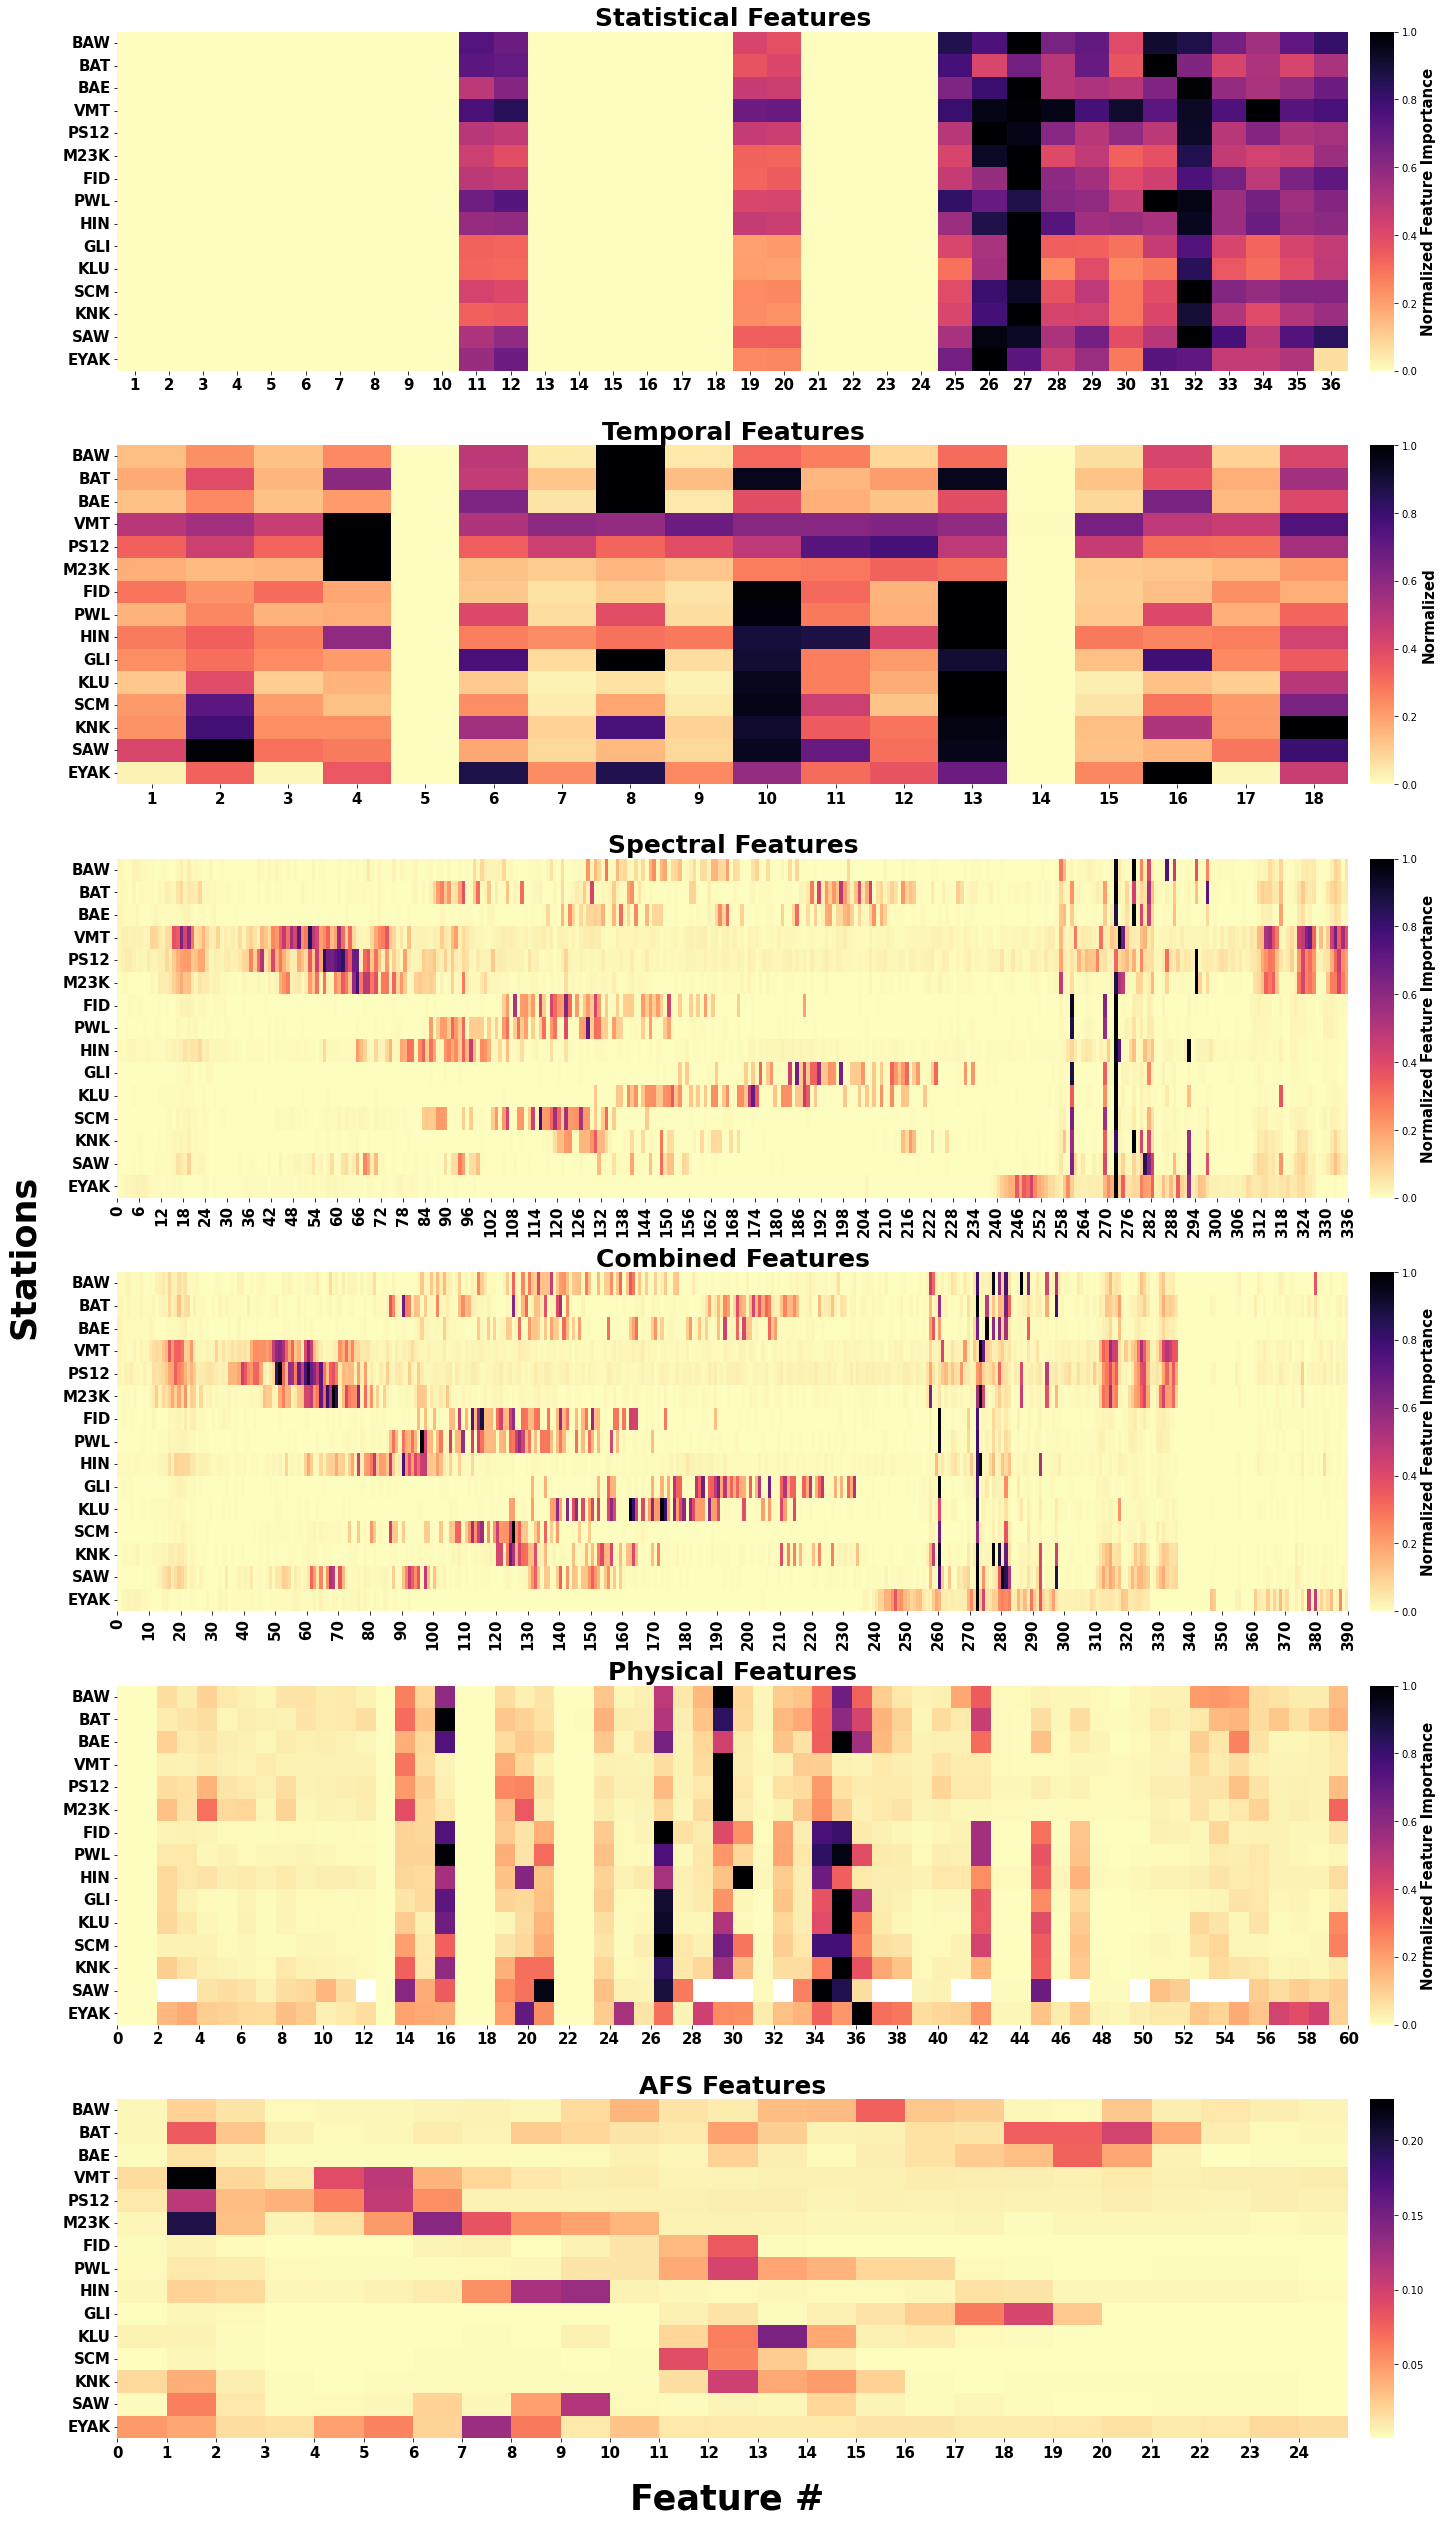

In [136]:
freq = np.fft.fftfreq(1500, 1/50)
importances_temporal = np.mean(np.array(Imp_temp), axis = 1)
importances_statistical = np.mean(np.array(Imp_stat), axis = 1)
importances_spectral = np.mean(np.array(Imp_spec), axis = 1)
importances_all = np.mean(np.array(Imp_all), axis = 1)
importances_afs = np.mean(np.array(Imp_afs), axis = 1)
importances_phy = sample_df

## Plotting feature importances of all feature types and across all stations. 


## getting the order of the stations according to number of available waveforms. 
no_of_icequakes = []
no_of_earthquakes = []
for i in range(15):
    no_of_icequakes.append(len(glob('../Data/icequake_waveforms/*'+stations[i]+'*')))
    no_of_earthquakes.append(len(glob('../Data/earthquake_waveforms/*'+stations[i]+'*')))
    
    
total_events = np.array(no_of_icequakes)+np.array(no_of_earthquakes)
order = np.argsort(total_events)


## Normalizing importances of temporal features. 
importances_norm_temp = []

for i in range(len(importances_temporal)):
    importances_norm_temp.append(importances_temporal[i]/np.max(importances_temporal[i]))
    
plt.rcParams['axes.linewidth'] = 2
grid_spec = {"width_ratios": (25, 0.5)}

fig, ax1 = plt.subplots(6,2, gridspec_kw=grid_spec, figsize=[20,35])
ax = sns.heatmap(np.array(importances_norm_temp)[order],cbar_ax=ax1[1][1], ax=ax1[1][0], cmap = 'magma_r')
ax.set_xticklabels([str(i) for i in range(1,len(importances_norm_temp[0])+1)], fontsize=15, fontweight='bold')
ax.set_yticklabels(stations[order], fontsize=15, fontweight='bold', rotation=0)
#ax.set_xlabel('Feature #', fontsize=25, fontweight='bold')
#ax.set_ylabel('Stations', fontsize=25, fontweight='bold')
ax.set_title('Temporal Features', fontsize=25, fontweight='bold')
ax1[1][1].set_ylabel('Normalized', fontsize=15, fontweight='bold')




importances_norm_stat = []

for i in range(len(importances_statistical)):
    importances_norm_stat.append(importances_statistical[i]/np.max(importances_statistical[i]))
    
ax = sns.heatmap(np.array(importances_norm_stat)[order],cbar_ax=ax1[0][1], ax=ax1[0][0], cmap = 'magma_r')
ax.set_xticklabels([str(i) for i in range(1,len(importances_norm_stat[0])+1)], fontsize=15, fontweight='bold')
ax.set_yticklabels(stations[order], fontsize=15, fontweight='bold', rotation=0)
#ax.set_xlabel('Feature #', fontsize=25, fontweight='bold')
#ax.set_ylabel('Stations', fontsize=25, fontweight='bold')
ax.set_title('Statistical Features', fontsize=25, fontweight='bold')
ax1[0][1].set_ylabel('Normalized Feature Importance', fontsize=15, fontweight='bold')


importances_norm_spec = []

for i in range(len(importances_spectral)):
    importances_norm_spec.append(importances_spectral[i]/np.max(importances_spectral[i]))
    

ax = sns.heatmap(np.array(importances_norm_spec)[order],cbar_ax=ax1[2][1], ax=ax1[2][0], cmap = 'magma_r')
ax.set_xticks(np.linspace(0,336,57))
ax.set_xticklabels([str(i) for i in range(0,337,6)], fontsize=15, fontweight='bold')
ax.set_yticklabels(stations[order], fontsize=15, fontweight='bold', rotation=0)
#ax.set_xlabel('Feature #', fontsize=25, fontweight='bold')
#ax.set_ylabel('Stations', fontsize=25, fontweight='bold')
ax.set_title('Spectral Features', fontsize=25, fontweight='bold')
ax1[2][1].set_ylabel('Normalized Feature Importance', fontsize=15, fontweight='bold')



importances_norm_all = []

for i in range(len(importances_all)):
    importances_norm_all.append(importances_all[i]/np.max(importances_all[i]))
    
ax = sns.heatmap(np.array(importances_norm_all)[order],cbar_ax= ax1[3][1], ax=ax1[3][0], cmap = 'magma_r')
ax.set_xticks(np.linspace(0,390,40))
ax.set_xticklabels([str(i) for i in range(0,400,10)], fontsize=15, fontweight='bold')
ax.set_yticklabels(stations[order], fontsize=15, fontweight='bold', rotation=0)
#ax.set_xlabel('Feature #', fontsize=25, fontweight='bold')
#ax.set_ylabel('Stations', fontsize=25, fontweight='bold')
ax.set_title('Combined Features', fontsize=25, fontweight='bold')
ax1[3][1].set_ylabel('Normalized Feature Importance', fontsize=15, fontweight='bold')



importances_norm_phy = []

for i in range(len(importances_phy)):
    importances_norm_phy.append(importances_phy.values.astype('float')[i]/np.nanmax(importances_phy.values.astype('float')[i]))
    
ax = sns.heatmap(np.array(importances_norm_phy)[order],cbar_ax= ax1[4][1], ax=ax1[4][0], cmap = 'magma_r')
ax.set_xticks(np.linspace(0,len(importances_norm_phy[0]),len(importances_norm_phy[0])//2))
ax.set_xticklabels([str(i) for i in range(0,len(importances_norm_phy[0]),2)], fontsize=15, fontweight='bold')
ax.set_yticklabels(stations[order], fontsize=15, fontweight='bold', rotation=0)
#ax.set_xlabel('Feature #', fontsize=25, fontweight='bold')
#ax.set_ylabel('Stations', fontsize=25, fontweight='bold')
ax.set_title('Physical Features', fontsize=25, fontweight='bold')
ax1[3][1].set_ylabel('Normalized Feature Importance', fontsize=15, fontweight='bold')

















importances_norm_afs = []

for i in range(len(importances_afs)):
    importances_norm_afs.append(importances_afs[i]/np.max(importances_afs[i]))

feature_importance = pd.DataFrame(np.array(importances_norm_afs)[:,0:1500][order], columns=freq[0:1500])
feature_i = feature_importance.values
smoothed_fi = []

for i in range(len(feature_importance)):
    win_sum = []
    for j in range(0,len(feature_i[i]), 60):
            win_sum.append(np.sum(feature_i[i,j:j+60])/60)
    smoothed_fi.append(win_sum)
    
ax = sns.heatmap(smoothed_fi,cbar_ax= ax1[5][1], ax=ax1[5][0], cmap = 'magma_r')
ax.set_xticks(np.linspace(0,24,25))
ax.set_xticklabels([str(i) for i in range(25)], fontsize=15, fontweight='bold')
ax.set_yticklabels(stations[order], fontsize=15, fontweight='bold', rotation=0)
#ax.set_xlabel('Feature #', fontsize=25, fontweight='bold')
#ax.set_ylabel('Stations', fontsize=25, fontweight='bold')
ax.set_title('AFS Features', fontsize=25, fontweight='bold')
ax1[4][1].set_ylabel('Normalized Feature Importance', fontsize=15, fontweight='bold')


fig.supxlabel('Feature #', y = 0.0, fontsize = 35, fontweight = 'bold')
fig.supylabel('Stations', x = 0.0, fontsize = 35, fontweight = 'bold')

plt.tight_layout()

In [218]:
importances_phy.columns.values

array(['Unnamed: 0', 'Window_Length', 'RappMaxMean', 'RappMaxMedian',
       'AsDec', 'KurtoSig', 'KurtoEnv', 'SkewSig', 'SkewEnv',
       'CorPeakNumber', 'Energy1/3Cor', 'Energy2/3Cor', 'int_ratio',
       'E_0.1_1', 'E_1_3', 'E_3_10', 'E_10_20', 'E_20_50', 'Kurt_0.1_1',
       'Kurt_1_3', 'Kurt_3_10', 'Kurt_10_20', 'Kurt_20_50',
       'RMSDecPhaseLine', 'MeanFFT', 'MaxFFT', 'FMaxFFT', 'MedianFFT',
       'VarFFT', 'FCentroid', 'Fquart1', 'Fquart3', 'NPeakFFT',
       'MeanPeaksFFT', 'E1FFT', 'E2FFT', 'E3FFT', 'E4FFT', 'Gamma1',
       'Gamma2', 'KurtoMaxDFT', 'KurtoMedianDFT', 'MaxOverMeanDFT',
       'MaxOverMedianDFT', 'NbrPeaksMaxDFT', 'NbrPeaksMeanDFT',
       'NbrPeaksMedianDFT', '45/46', '45/47', 'NbrPeaksCentralFreq',
       'NbrPeaksMaxFreq', '50/51', 'DistMaxMeanFreqDTF',
       'DistMaxMedianFreqDTF', 'DistQ2Q1DFT', 'DistQ3Q2DFT', 'DistQ3Q1DFT',
       'Peak_Envelope_Amplitude', 'Average_Envelope_Amplitude',
       'Envelope_Area', 'Envelope_Velocity', 'Envelope_Rise_Time

In [222]:
fi_stat = np.mean(importances_stat, axis = 0)
fi_temp = np.mean(importances_temp, axis = 0)
fi_spec = np.mean(importances_spec, axis = 0)
fi_phy = np.nanmean(importances_phy.values, axis = 0)


f_stat = np.array([stat_features[i].split('_', 1)[1] for i in range(len(stat_features))])
f_temp = np.array([temp_features[i].split('_', 1)[1] for i in range(len(temp_features))])
f_spec = np.array([spec_features[i].split('_',1)[1] for i in range(len(spec_features))])
f_phy = importances_phy.columns.values


    


In [223]:
stat_df = pd.DataFrame([])
stat_df['Features'] = f_stat
stat_df['Importance'] = fi_stat


temp_df = pd.DataFrame([])
temp_df['Features'] = f_temp
temp_df['Importance'] = fi_temp


spec_df = pd.DataFrame([])
spec_df['Features'] = f_spec
spec_df['Importance'] = fi_spec


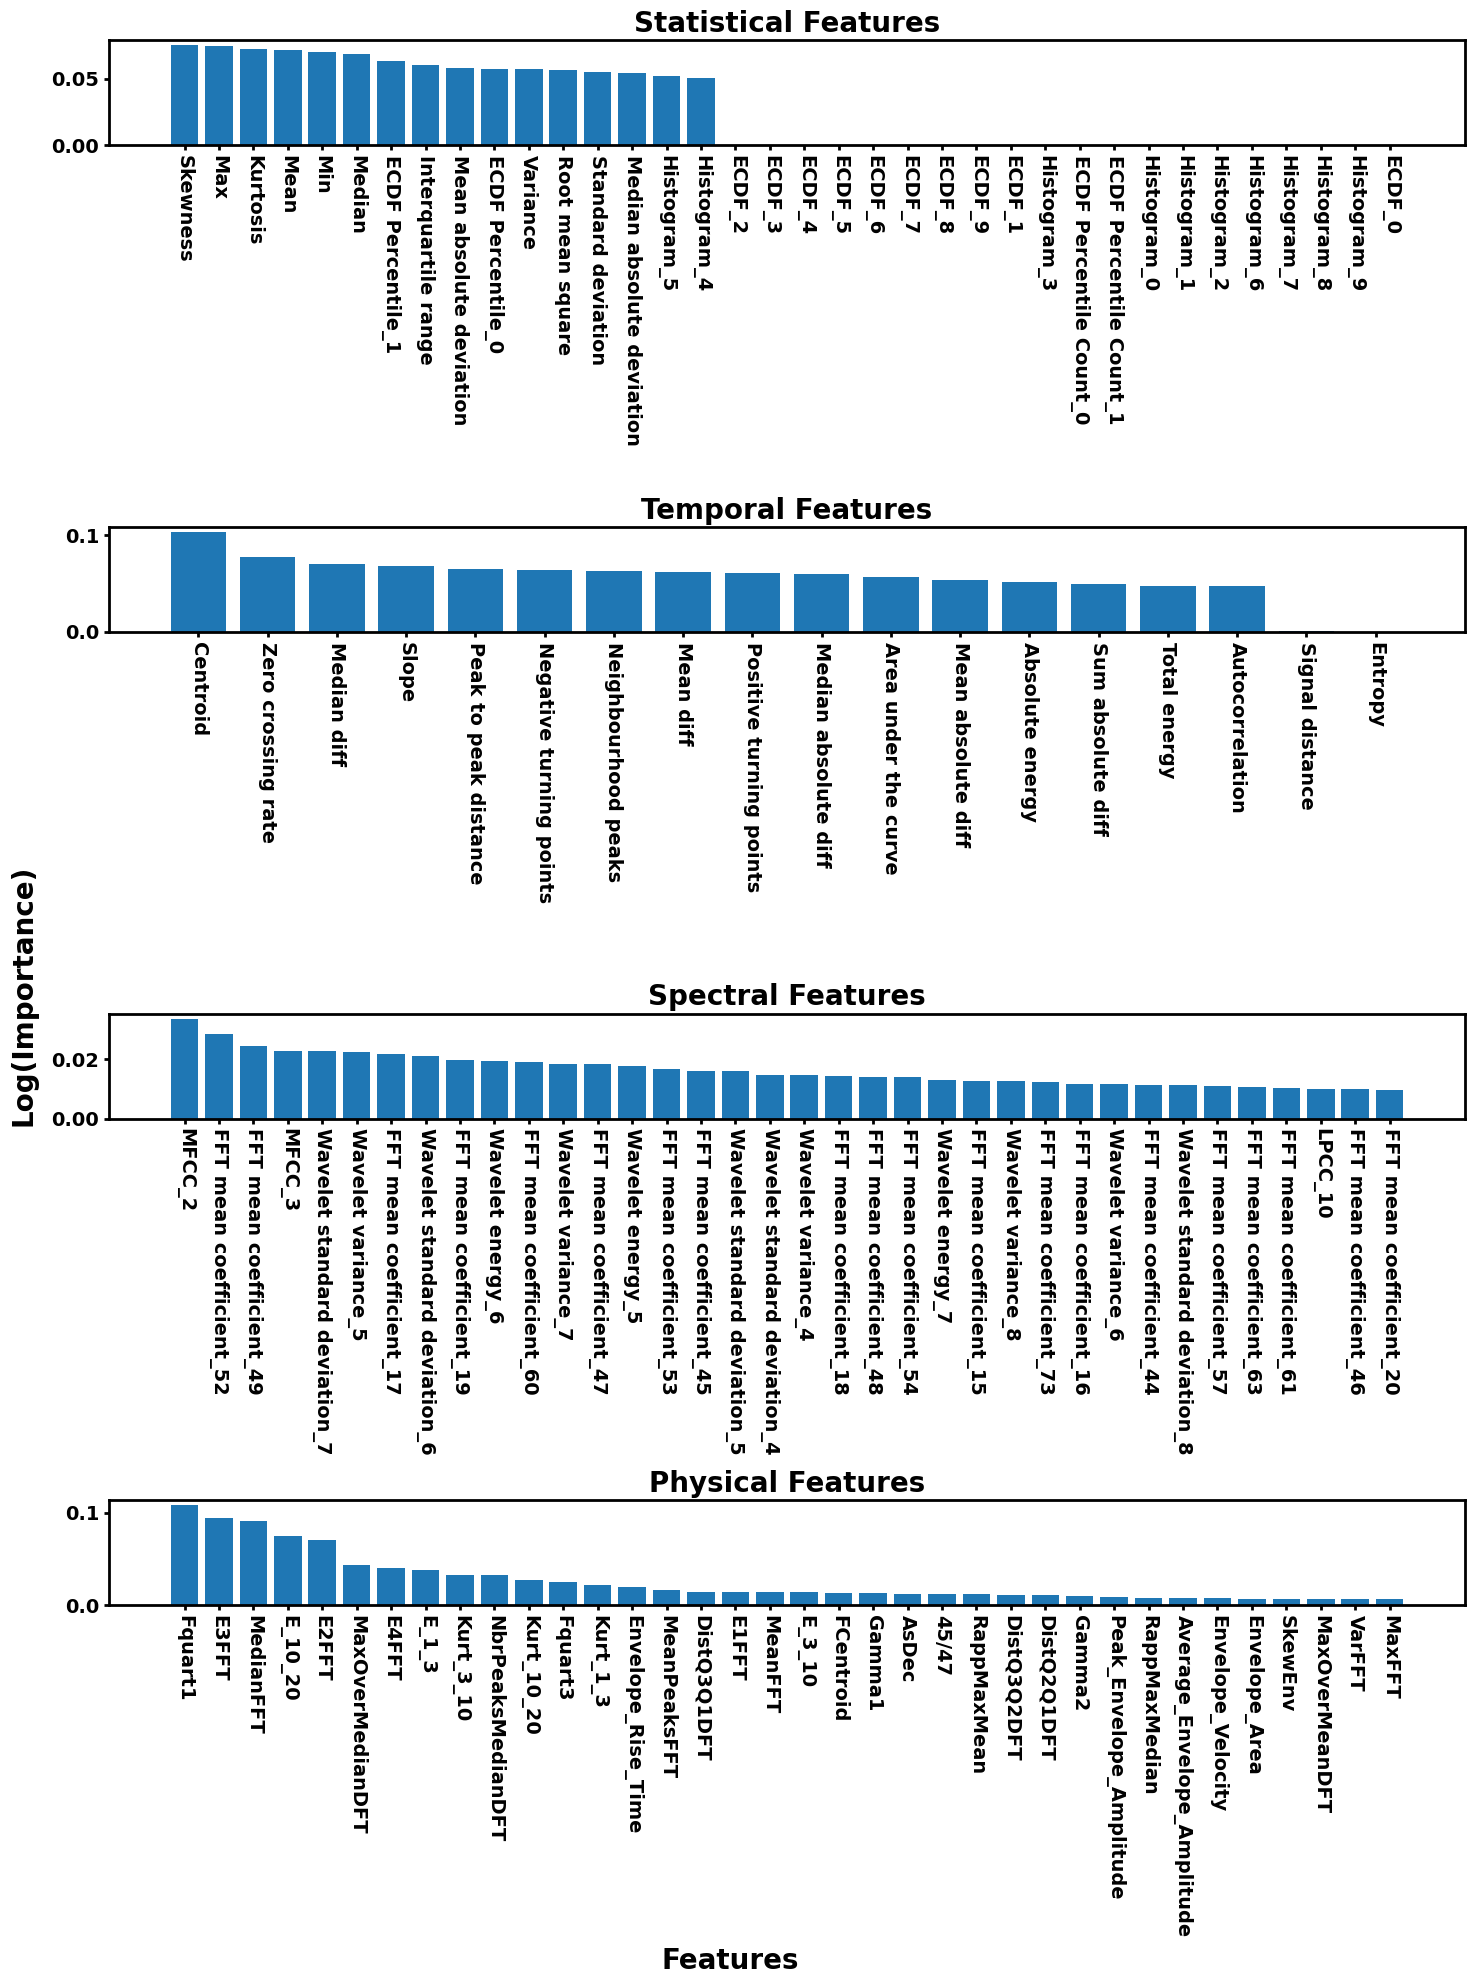

In [483]:
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['font.weight'] = 'bold'


fig, ax = plt.subplots(nrows = 4, ncols = 1, figsize = [15,20])
ax[0].bar(x = np.arange(len(fi_stat)), height = np.sort(fi_stat)[::-1])
ax[0].set_xticks(np.arange(len(fi_stat)))
ax[0].set_xticklabels(labels = f_stat[np.argsort(fi_stat)][::-1], rotation = 270)
ax[0].set_title('Statistical Features', fontweight = 'bold', fontsize = 20)
#ax[0].set_yscale('log')

ax[1].bar(x = np.arange(len(fi_temp)), height = np.sort(fi_temp)[::-1])
ax[1].set_xticks(np.arange(len(fi_temp)))
ax[1].set_xticklabels(labels = f_temp[np.argsort(fi_temp)][::-1], rotation = 270)
ax[1].set_title('Temporal Features', fontweight = 'bold', fontsize = 20)
#ax[1].set_yscale('log')



ax[2].bar(x = np.arange(len(fi_spec))[0:36], height = np.sort(fi_spec)[::-1][0:36])
ax[2].set_xticks(np.arange(len(fi_spec))[0:36])
ax[2].set_xticklabels(labels = f_spec[np.argsort(fi_spec)][::-1][0:36], rotation = 270)
ax[2].set_title('Spectral Features', fontweight = 'bold', fontsize = 20)
#ax[2].set_yscale('log')

ax[3].bar(x = np.arange(len(fi_phy))[0:36], height = np.sort(fi_phy)[::-1][0:36])
ax[3].set_xticks(np.arange(len(fi_phy))[0:36])
ax[3].set_xticklabels(labels = f_phy[np.argsort(fi_phy)][::-1][0:36], rotation = 270)
ax[3].set_title('Physical Features', fontweight = 'bold', fontsize = 20)
#ax[3].set_yscale('log')


fig.supxlabel('Features', fontsize = 20, fontweight ='bold')
fig.supylabel('Log(Importance)', fontsize = 20, fontweight ='bold')
#fig.supylabel('Mean Feature importances over stations', fontsize = 20, fontweight ='bold', x = 0)
fig.tight_layout()

In [486]:
fi_stat

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.05768684,  0.06326326,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.05094869,  0.0521017 ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.06034066,
        0.07253295,  0.07480103,  0.07213721,  0.05828991,  0.06889543,
        0.05426221,  0.0701927 ,  0.05667706,  0.0753142 ,  0.05517593,
        0.05738021])

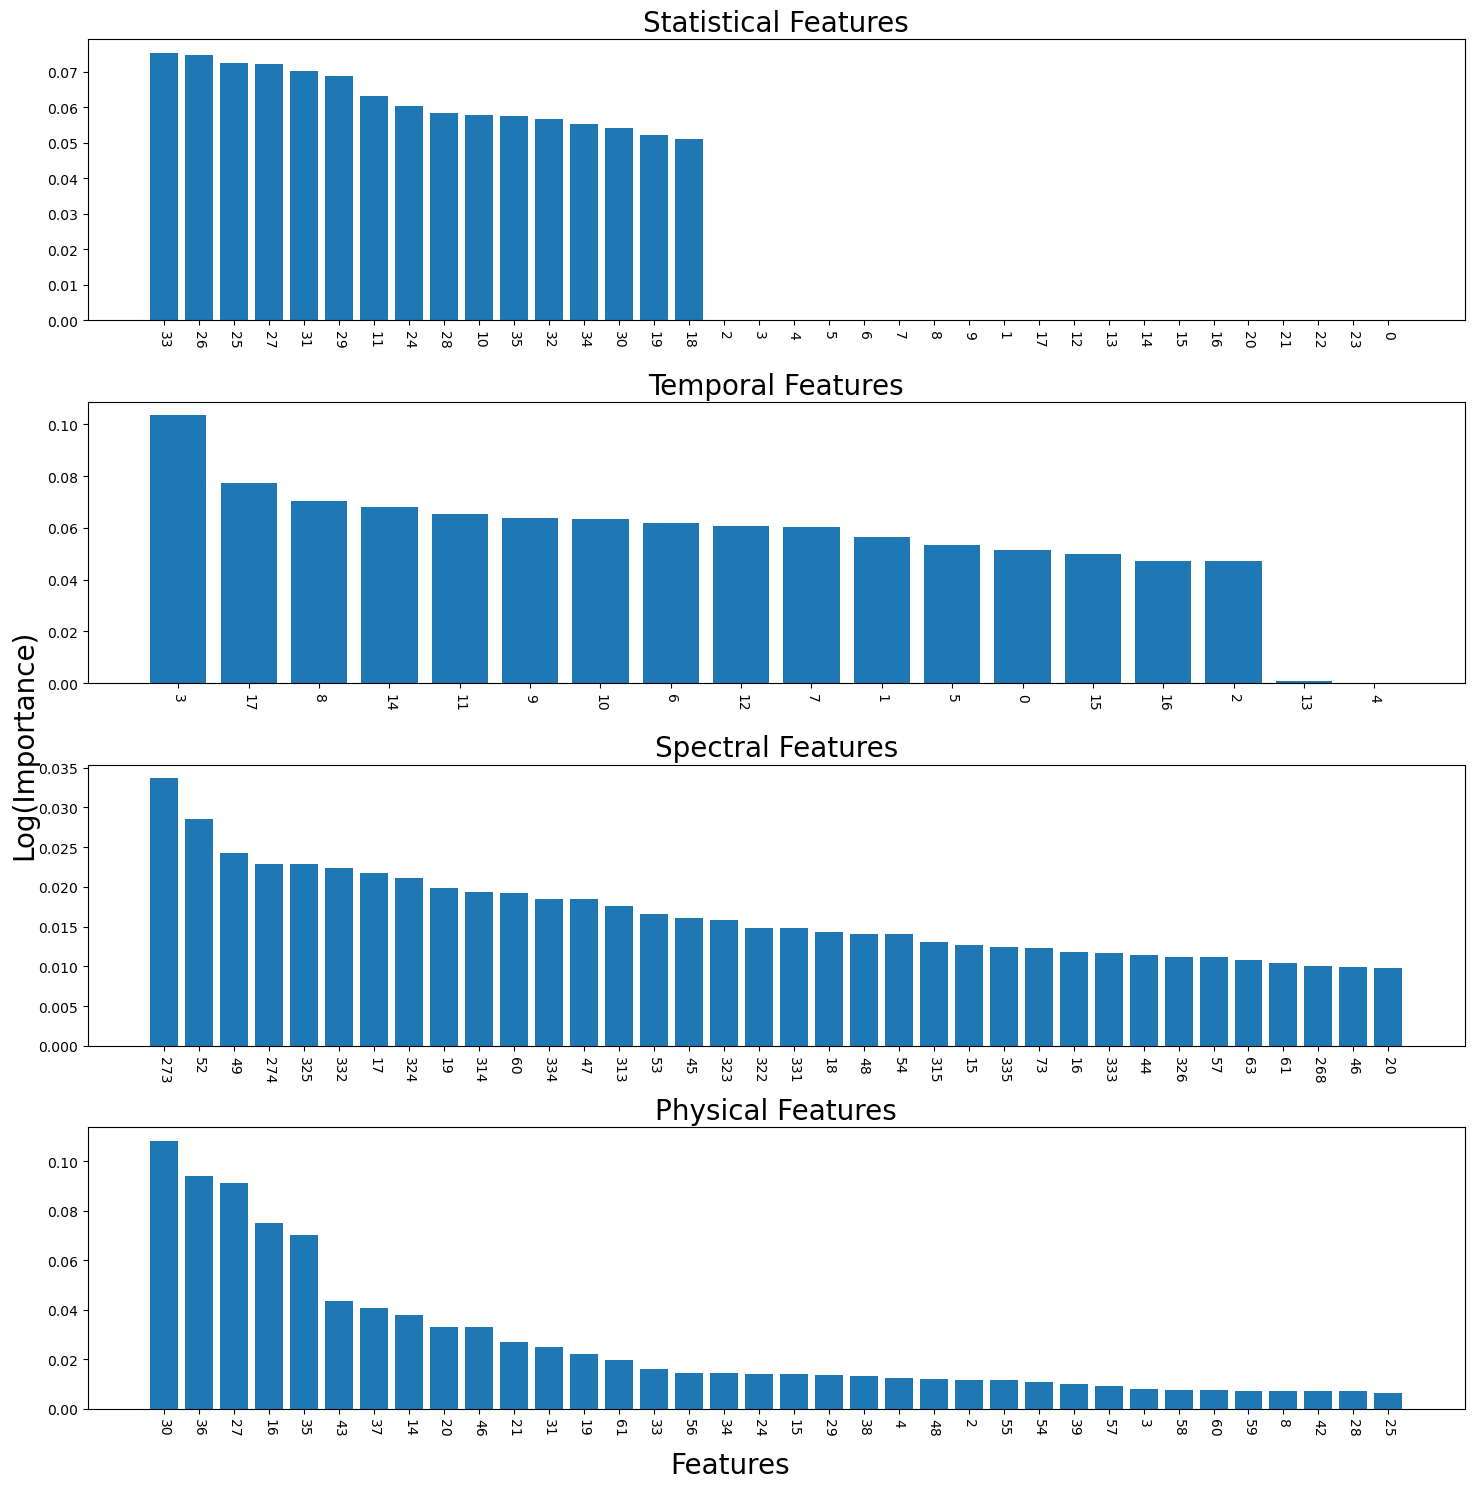

In [491]:
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.width'] = 2


plt.style.use('default')
fig, ax = plt.subplots(nrows = 4, ncols = 1, figsize = [15,15])
ax[0].bar(x = np.arange(len(fi_stat)), height = np.sort(fi_stat)[::-1])
ax[0].set_xticks(np.arange(len(fi_stat)))
ax[0].set_xticklabels(labels = [str(i) for i in np.argsort(fi_stat)][::-1], rotation = 270)
ax[0].set_title('Statistical Features', fontsize = 20)
#ax[0].set_yscale('log')

ax[1].bar(x = np.arange(len(fi_temp)), height = np.sort(fi_temp)[::-1])
ax[1].set_xticks(np.arange(len(fi_temp)))
ax[1].set_xticklabels(labels = [str(i) for i in np.argsort(fi_temp)][::-1], rotation = 270)
ax[1].set_title('Temporal Features', fontsize = 20)
#ax[1].set_yscale('log')



ax[2].bar(x = np.arange(len(fi_spec))[0:36], height = np.sort(fi_spec)[::-1][0:36])
ax[2].set_xticks(np.arange(len(fi_spec))[0:36])
ax[2].set_xticklabels(labels = [str(i) for i in np.argsort(fi_spec)][::-1][0:36], rotation = 270)
ax[2].set_title('Spectral Features', fontsize = 20)
#ax[2].set_yscale('log')

ax[3].bar(x = np.arange(len(fi_phy))[0:36], height = np.sort(fi_phy)[::-1][0:36])
ax[3].set_xticks(np.arange(len(fi_phy))[0:36])
ax[3].set_xticklabels(labels = [str(i) for i in np.argsort(fi_phy)][::-1][0:36], rotation = 270)
ax[3].set_title('Physical Features', fontsize = 20)
#ax[3].set_yscale('log')


fig.supxlabel('Features', fontsize = 20)
fig.supylabel('Log(Importance)', fontsize = 20)
#fig.supylabel('Mean Feature importances over stations', fontsize = 20, fontweight ='bold', x = 0)
fig.tight_layout()

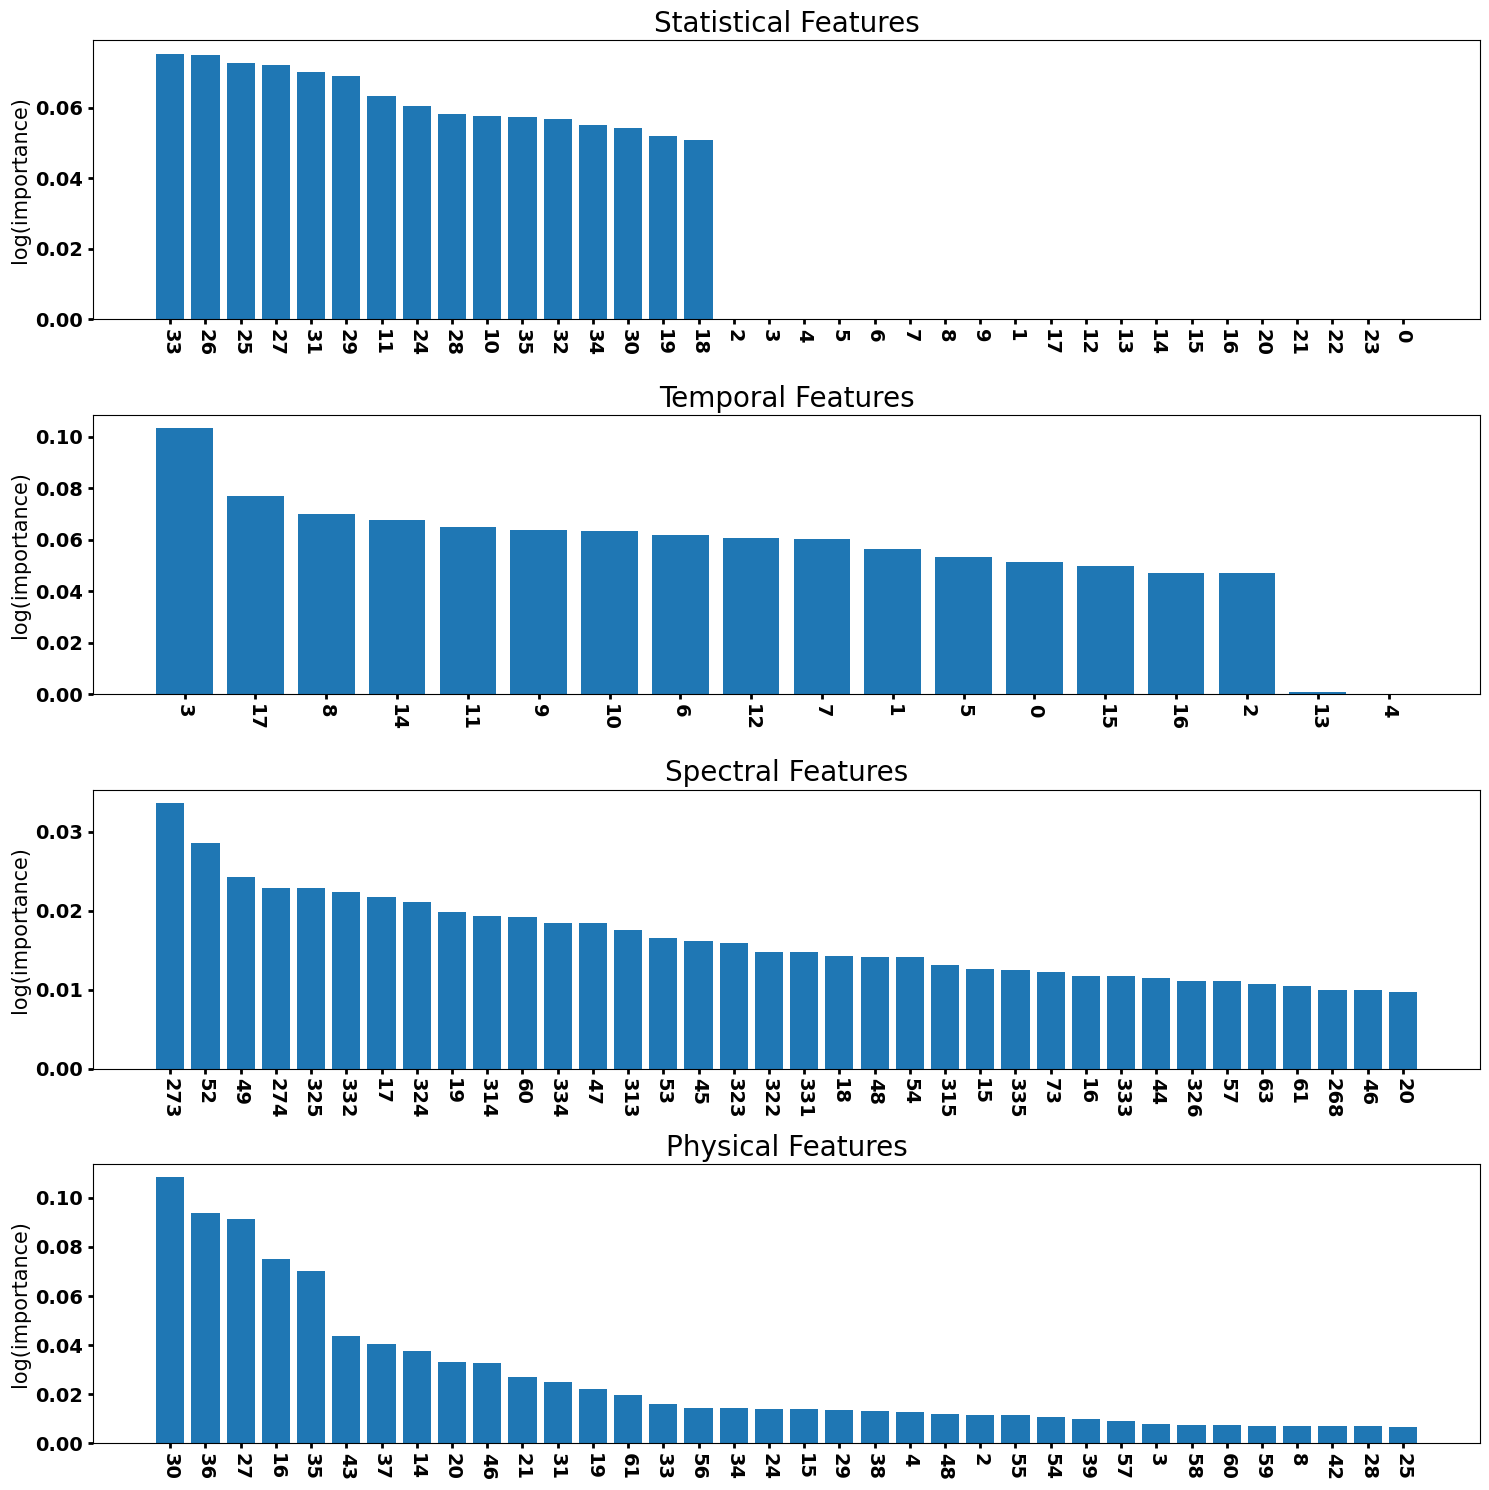

In [496]:
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['font.weight'] = 'bold'


fig, ax = plt.subplots(nrows = 4, ncols = 1, figsize = [15,15])
ax[0].bar(x = np.arange(len(fi_stat)), height = np.sort(fi_stat)[::-1])
ax[0].set_xticks(np.arange(len(fi_stat)))
ax[0].set_xticklabels(labels = [str(i) for i in np.argsort(fi_stat)][::-1], rotation = 270)
ax[0].set_title('Statistical Features', fontsize = 20)
ax[0].set_ylabel('log(importance)', fontsize  = 15)
#ax[0].set_yscale('log')

ax[1].bar(x = np.arange(len(fi_temp)), height = np.sort(fi_temp)[::-1])
ax[1].set_xticks(np.arange(len(fi_temp)))
ax[1].set_xticklabels(labels = [str(i) for i in np.argsort(fi_temp)][::-1], rotation = 270)
ax[1].set_title('Temporal Features', fontsize = 20)
ax[1].set_ylabel('log(importance)', fontsize  = 15)
#ax[1].set_yscale('log')



ax[2].bar(x = np.arange(len(fi_spec))[0:36], height = np.sort(fi_spec)[::-1][0:36])
ax[2].set_xticks(np.arange(len(fi_spec))[0:36])
ax[2].set_xticklabels(labels = [str(i) for i in np.argsort(fi_spec)][::-1][0:36], rotation = 270)
ax[2].set_title('Spectral Features', fontsize = 20)
ax[2].set_ylabel('log(importance)', fontsize  = 15)
#ax[2].set_yscale('log')

ax[3].bar(x = np.arange(len(fi_phy))[0:36], height = np.sort(fi_phy)[::-1][0:36])
ax[3].set_xticks(np.arange(len(fi_phy))[0:36])
ax[3].set_xticklabels(labels = [str(i) for i in np.argsort(fi_phy)][::-1][0:36], rotation = 270)
ax[3].set_title('Physical Features', fontsize = 20)
ax[3].set_ylabel('log(importance)', fontsize  = 15)
#ax[3].set_yscale('log')


#fig.supxlabel('Features', fontsize = 20)
#fig.supylabel('Log(Importance)', fontsize = 20)
#fig.supylabel('Mean Feature importances over stations', fontsize = 20, fontweight ='bold', x = 0)
fig.tight_layout()

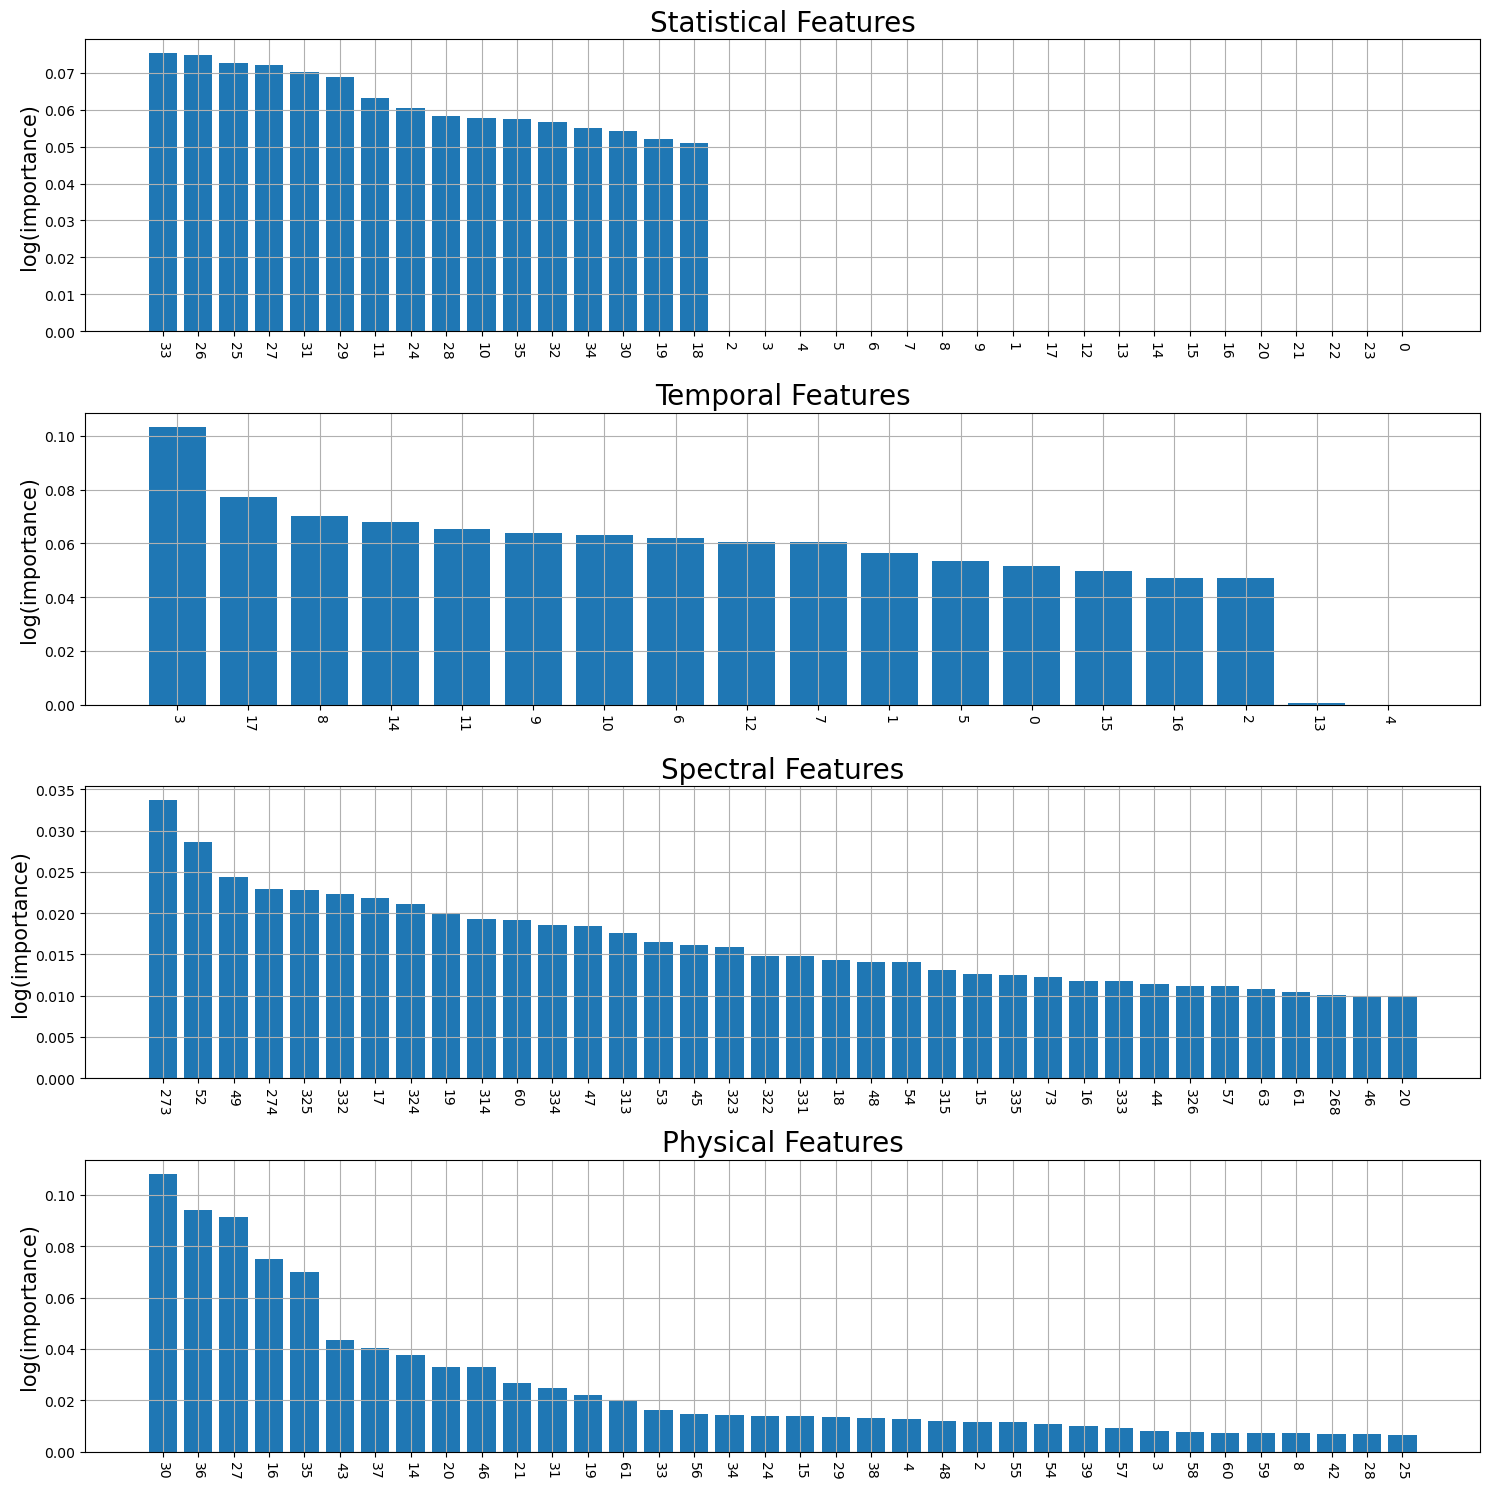

In [499]:
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.width'] = 2
#mpl.rcParams['font.weight'] = 'bold'


plt.style.use('default')
fig, ax = plt.subplots(nrows = 4, ncols = 1, figsize = [15,15])
ax[0].bar(x = np.arange(len(fi_stat)), height = np.sort(fi_stat)[::-1])
ax[0].set_xticks(np.arange(len(fi_stat)))
ax[0].set_xticklabels(labels = [str(i) for i in np.argsort(fi_stat)][::-1], rotation = 270)
ax[0].set_title('Statistical Features', fontsize = 20)
ax[0].set_ylabel('log(importance)', fontsize  = 15)
#ax[0].set_yscale('log')

ax[1].bar(x = np.arange(len(fi_temp)), height = np.sort(fi_temp)[::-1])
ax[1].set_xticks(np.arange(len(fi_temp)))
ax[1].set_xticklabels(labels = [str(i) for i in np.argsort(fi_temp)][::-1], rotation = 270)
ax[1].set_title('Temporal Features', fontsize = 20)
ax[1].set_ylabel('log(importance)', fontsize  = 15)
#ax[1].set_yscale('log')



ax[2].bar(x = np.arange(len(fi_spec))[0:36], height = np.sort(fi_spec)[::-1][0:36])
ax[2].set_xticks(np.arange(len(fi_spec))[0:36])
ax[2].set_xticklabels(labels = [str(i) for i in np.argsort(fi_spec)][::-1][0:36], rotation = 270)
ax[2].set_title('Spectral Features', fontsize = 20)
ax[2].set_ylabel('log(importance)', fontsize  = 15)
#ax[2].set_yscale('log')

ax[3].bar(x = np.arange(len(fi_phy))[0:36], height = np.sort(fi_phy)[::-1][0:36])
ax[3].set_xticks(np.arange(len(fi_phy))[0:36])
ax[3].set_xticklabels(labels = [str(i) for i in np.argsort(fi_phy)][::-1][0:36], rotation = 270)
ax[3].set_title('Physical Features', fontsize = 20)
ax[3].set_ylabel('log(importance)', fontsize  = 15)
#ax[3].set_yscale('log')


ax[0].grid(True)
ax[1].grid(True)
ax[2].grid(True)
ax[3].grid(True)


#fig.supxlabel('Features', fontsize = 20)
#fig.supylabel('Log(Importance)', fontsize = 20)
#fig.supylabel('Mean Feature importances over stations', fontsize = 20, fontweight ='bold', x = 0)
fig.tight_layout()

## Exploring group wise important features

In [445]:
mean_importance_spec = np.mean(Imp_spec, axis = 1)
mean_importance_temp = np.mean(Imp_temp, axis = 1)
mean_importance_stat = np.mean(Imp_stat, axis = 1)
mean_importance_phy = np.array(importances_phy)

In [453]:
spec_imp_1 = np.mean(mean_importance_spec[[0,1,2]], axis = 0)
spec_imp_2 = np.mean(mean_importance_spec[[9,10,14]], axis = 0)
spec_imp_3 = np.mean(mean_importance_spec[[4,5,7,8,11,12,13]], axis = 0)
spec_imp_4 = np.mean(mean_importance_spec[[3,6]], axis = 0)

  
    
temp_imp_1 = np.mean(mean_importance_temp[[0,1,2]], axis = 0)
temp_imp_2 = np.mean(mean_importance_temp[[9,10,14]], axis = 0)
temp_imp_3 = np.mean(mean_importance_temp[[4,5,7,8,11,12,13]], axis = 0)
temp_imp_4 = np.mean(mean_importance_temp[[3,6]], axis = 0)


stat_imp_1 = np.mean(mean_importance_stat[[0,1,2]], axis = 0)
stat_imp_2 = np.mean(mean_importance_stat[[9,10,14]], axis = 0)
stat_imp_3 = np.mean(mean_importance_stat[[4,5,7,8,11,12,13]], axis = 0)
stat_imp_4 = np.mean(mean_importance_stat[[3,6]], axis = 0)

phy_imp_1 = np.mean(mean_importance_phy[[0,1,2]], axis = 0)
phy_imp_2 = np.mean(mean_importance_phy[[9,10,14]], axis = 0)
phy_imp_3 = np.mean(mean_importance_phy[[4,5,7,8,11,12,13]], axis = 0)
phy_imp_4 = np.mean(mean_importance_phy[[3,6]], axis = 0)

In [468]:
import numpy as np

fs = 50
nfft = 512
nfilt = 40

# Compute the Mel-scale frequencies
low_freq_mel = 0
high_freq_mel = (2595 * np.log10(1 + (fs / 2) / 700))
mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)

# Convert Mel-scale frequencies to Hz-scale frequencies
hz_points = (700 * (10 ** (mel_points / 2595) - 1))

# Find the frequency correspoding to the second MFCC
second_mfcc_freq = hz_points[11]

print("Frequency corresponding to the second MFCC:", second_mfcc_freq, "Hz")


Frequency corresponding to the second MFCC: 6.62144171932 Hz


## Plotting the top 5 most important features

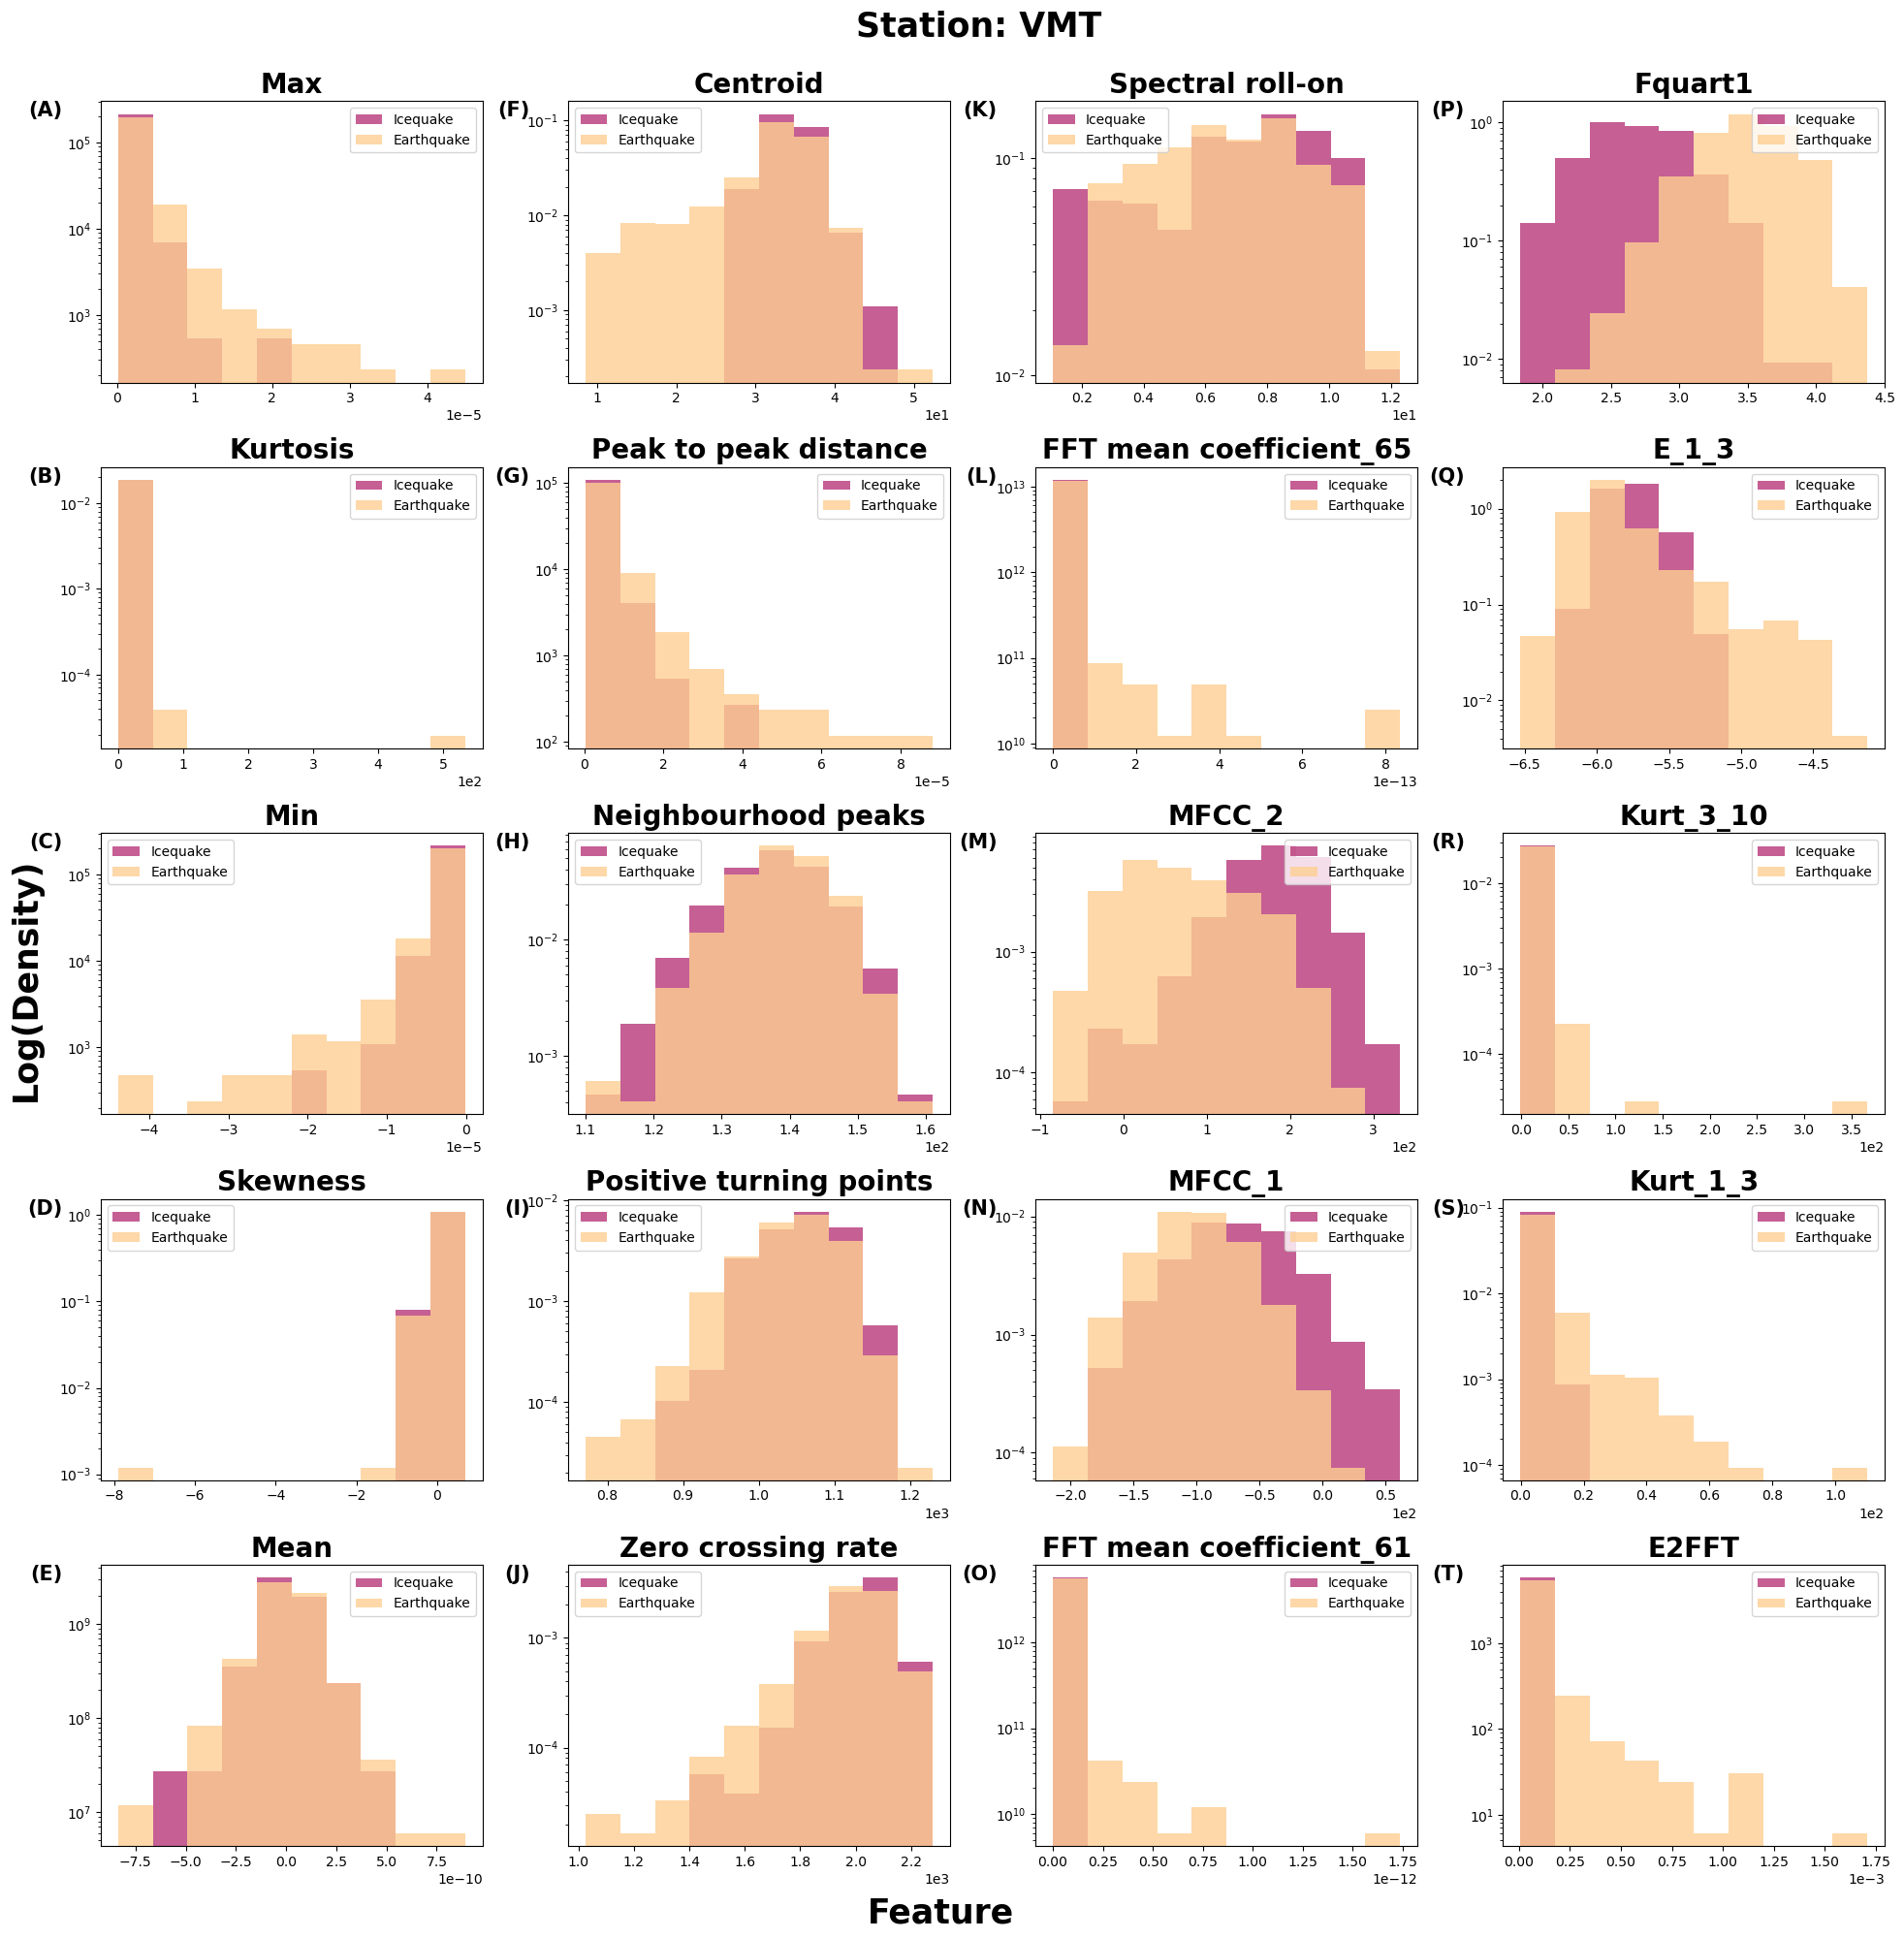

In [459]:
import string

cmap = matplotlib.cm.get_cmap('magma')

c1 = cmap(0.1)
c2 = cmap(0.3)
c3 = cmap(0.5)
c4 = cmap(0.7)
c5 = cmap(0.9)
c6 = cmap(1.0)


plt.style.use('default')
station = 'VMT'

if station == 'BAE':

    
    top_5_stat = stat_features[np.argsort(stat_imp_1)[::-1][0:5]]
    top_5_temp = temp_features[np.argsort(temp_imp_1)[::-1][0:5]]
    top_5_spec = spec_features[np.argsort(spec_imp_1)[::-1][0:5]]
    top_5_phy = f_phy[np.argsort(phy_imp_1)[::-1][0:5]]

    
if station == 'VMT':

    
    top_5_stat = stat_features[np.argsort(stat_imp_2)[::-1][0:5]]
    top_5_temp = temp_features[np.argsort(temp_imp_2)[::-1][0:5]]
    top_5_spec = spec_features[np.argsort(spec_imp_2)[::-1][0:5]]
    top_5_phy = f_phy[np.argsort(phy_imp_2)[::-1][0:5]]
    
    
if station == 'SCM':

    
    top_5_stat = stat_features[np.argsort(stat_imp_3)[::-1][0:5]]
    top_5_temp = temp_features[np.argsort(temp_imp_3)[::-1][0:5]]
    top_5_spec = spec_features[np.argsort(spec_imp_3)[::-1][0:5]]
    top_5_phy = f_phy[np.argsort(phy_imp_3)[::-1][0:5]]
    
    
if station == 'HIN':

    
    top_5_stat = stat_features[np.argsort(stat_imp_4)[::-1][0:5]]
    top_5_temp = temp_features[np.argsort(temp_imp_4)[::-1][0:5]]
    top_5_spec = spec_features[np.argsort(spec_imp_4)[::-1][0:5]]
    top_5_phy = f_phy[np.argsort(phy_imp_4)[::-1][0:5]]
    
    




X1 = pd.read_csv('/home/ak287/Icequakes_vs_Tectonicquakes/Extracted_Features/Tsfel_features_1_25_'+station+'.csv')
X1_ice = X1[X1['label'] == 1]
X1_eq = X1[X1['label'] == 0]

fig, ax = plt.subplots(nrows = 5, ncols = 4, figsize = [20,20])
letters = list(string.ascii_uppercase)[:len(top_5_stat)]

for i in range(len(top_5_stat)):
    X1_ice_data = X1_ice.loc[:, top_5_stat].values[:,i]
    X1_eq_data = X1_eq.loc[:, top_5_stat].values[:,i]
    
    
    # Calculate the range for the bins
    data_min = min(np.min(X1_ice_data), np.min(X1_eq_data))
    data_max = max(np.max(X1_ice_data), np.max(X1_eq_data))
    bin_range = (data_min, data_max)

    # Plot the histograms with the same bin width
    ax[i][0].hist(X1_ice_data, alpha=0.8, density=True , range= bin_range, label='Icequake', color = c3)
    ax[i][0].hist(X1_eq_data, alpha=0.8, density=True, range= bin_range, label='Earthquake', color = c5)
    ax[i][0].legend()
    ax[i][0].set_title(top_5_stat[i].split('_',1)[1], fontsize = 20, fontweight = 'bold')
    ax[i][0].set_yscale('log')
    
    ax[i, 0].annotate(f"({letters[i]})", xy=(-0.1, 1), xycoords='axes fraction', ha='right', va='top', fontsize=15, fontweight = 'bold')
    ax[i, 0].ticklabel_format(style='sci', axis='x', scilimits=(0, 0))

    
letters = list(string.ascii_uppercase)[len(top_5_stat):len(top_5_stat)+5]
for i in range(len(top_5_temp)):
    X1_ice_data = X1_ice.loc[:, top_5_temp].values[:,i]
    X1_eq_data = X1_eq.loc[:, top_5_temp].values[:,i]
    
    
    # Calculate the range for the bins
    data_min = min(np.min(X1_ice_data), np.min(X1_eq_data))
    data_max = max(np.max(X1_ice_data), np.max(X1_eq_data))
    bin_range = (data_min, data_max)

    # Plot the histograms with the same bin width
    ax[i][1].hist(X1_ice_data, alpha=0.8, density=True , range= bin_range, label='Icequake', color = c3)
    ax[i][1].hist(X1_eq_data, alpha=0.8, density=True, range= bin_range, label='Earthquake', color = c5)
    ax[i][1].legend()
    ax[i][1].set_title(top_5_temp[i].split('_',1)[1], fontsize = 20, fontweight = 'bold')
    ax[i][1].set_yscale('log')
    ax[i, 1].annotate(f"({letters[i]})", xy=(-0.1, 1), xycoords='axes fraction', ha='right', va='top', fontsize=15, fontweight = 'bold')
    ax[i, 1].ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
 
letters = list(string.ascii_uppercase)[len(top_5_stat)+5:len(top_5_stat)+10]
for i in range(len(top_5_spec)):
    X1_ice_data = X1_ice.loc[:, top_5_spec].values[:,i]
    X1_eq_data = X1_eq.loc[:, top_5_spec].values[:,i]
    
    
    # Calculate the range for the bins
    data_min = min(np.min(X1_ice_data), np.min(X1_eq_data))
    data_max = max(np.max(X1_ice_data), np.max(X1_eq_data))
    bin_range = (data_min, data_max)

    # Plot the histograms with the same bin width
    ax[i][2].hist(X1_ice_data, alpha=0.8, density=True , range= bin_range, label='Icequake', color = c3)
    ax[i][2].hist(X1_eq_data, alpha=0.8, density=True, range= bin_range, label='Earthquake', color = c5)
    ax[i][2].legend()
    ax[i][2].set_title(top_5_spec[i].split('_',1)[1], fontsize = 20, fontweight = 'bold')
    ax[i][2].set_yscale('log')
    ax[i, 2].annotate(f"({letters[i]})", xy=(-0.1, 1), xycoords='axes fraction', ha='right', va='top', fontsize=15, fontweight = 'bold')
    ax[i, 2].ticklabel_format(style='sci', axis='x', scilimits=(0, 0))

i = 0
X1 = pd.read_csv('/home/ak287/Icequakes_vs_Tectonicquakes/Extracted_Features/Physical_features_1_25_'+station+'.csv')
X1_ice = X1[X1['label'] == 1]
X1_eq = X1[X1['label'] == 0]
letters = list(string.ascii_uppercase)[len(top_5_stat)+10:len(top_5_stat)+15]
for i in range(len(top_5_phy)):
    X1_ice_data = X1_ice.loc[:, top_5_phy].values[:,i]
    X1_eq_data = X1_eq.loc[:, top_5_phy].values[:,i]
    
    
    # Calculate the range for the bins
    data_min = min(np.min(X1_ice_data), np.min(X1_eq_data))
    data_max = max(np.max(X1_ice_data), np.max(X1_eq_data))
    bin_range = (data_min, data_max)

    # Plot the histograms with the same bin width
    ax[i][3].hist(X1_ice_data, alpha=0.8, density=True , range= bin_range, label='Icequake', color = c3)
    ax[i][3].hist(X1_eq_data, alpha=0.8, density=True, range= bin_range, label='Earthquake', color = c5)
    ax[i][3].legend()
    ax[i][3].set_title(top_5_phy[i], fontsize = 20, fontweight = 'bold')
    ax[i][3].set_yscale('log')
    ax[i, 3].annotate(f"({letters[i]})", xy=(-0.1, 1), xycoords='axes fraction', ha='right', va='top', fontsize=15, fontweight = 'bold')
    ax[i, 3].ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
    


"""  
legend_elements = [
    plt.Line2D([0], [0], marker='s', color=c3, label='Icequake', markerfacecolor=c3, markersize=10),
    plt.Line2D([0], [0], marker='s', color=c4, label='Earthquake', markerfacecolor=c5, markersize=10)
    
]

# Create the legend from the custom elements
plt.legend(handles=legend_elements, loc='upper right')
"""
i = 0
fig.suptitle("Station: "+station,x =0.52, y = 1, fontsize = 25, fontweight = 'bold')
fig.supxlabel('Feature', fontsize = 25, fontweight = 'bold')
fig.supylabel('Log(Density)', fontsize = 25, fontweight = 'bold')
fig.tight_layout()

In [385]:
forest = RandomForestClassifier(random_state=0, n_estimators=100)
ACC = []
SPEC = []
SENS = []
DUR = []


for i in tqdm(range(len(stations))):

    X1 = pd.read_csv('/home/ak287/Icequakes_vs_Tectonicquakes/Extracted_Features/Tsfel_features_1_25_'+stations[i]+'.csv')
    y1 = X1['label']
    X_stand = StandardScaler().fit_transform(X1)
    X_stand = pd.DataFrame(X_stand)
    X_stand.columns = X1.columns

    X_all = X_stand.loc[:,all_features]
    
    temp_imp_all = np.mean(Imp_all, axis = 1)[i]
    
    indices = np.argsort(temp_imp_all)[::-1]
    
    
    acc = []
    spec = []
    sens = []
    dur = []
    
    for j in tqdm(range(1,len(indices))):
        temp_features = all_features[indices[0:j]]
        X_temp = X_all.loc[:, temp_features]
        X_Train, X_Test, y_Train, y_Test = train_test_split(X_temp, y1, test_size = 0.20, random_state = 101)
        
        
        star = time.process_time()
        model = forest.fit(X_Train, y_Train)
        dur.append(time.process_time() - start)
        
        
        predictionforest = model.predict(X_Test)
        #print(confusion_matrix(Y_Test,predictionforest))
        #print(classification_report(Y_Test,predictionforest))

        tn, fp, fn, tp = confusion_matrix(y_Test, predictionforest).ravel()
        spec.append(tn / (tn+fp))
        sens.append(tp / (tp+fn))
        acc.append(accuracy_score(y_Test, predictionforest))
        
        
    ACC.append(acc)
    SPEC.append(spec)
    SENS.append(sens)
    DUR.append(dur)

 40%|███▉      | 155/389 [00:33<01:05,  3.57it/s]


 79%|███████▉  | 309/389 [01:21<00:27,  2.91it/s]


 19%|█▉        | 74/389 [00:12<00:58,  5.39it/s]


 59%|█████▉    | 229/389 [00:47<00:39,  4.08it/s]


 98%|█████████▊| 383/389 [01:31<00:01,  3.42it/s]


 38%|███▊      | 148/389 [00:21<00:38,  6.19it/s]


 78%|███████▊  | 302/389 [00:49<00:16,  5.12it/s]


 17%|█▋        | 67/389 [01:08<08:02,  1.50s/it]


 57%|█████▋    | 222/389 [06:08<05:40,  2.04s/it]


 97%|█████████▋| 376/389 [11:46<00:28,  2.20s/it]


 36%|███▌      | 141/389 [02:17<06:09,  1.49s/it]


 76%|███████▌  | 295/389 [07:27<03:52,  2.48s/it]


 15%|█▌        | 60/389 [00:47<05:51,  1.07s/it]


 55%|█████▌    | 215/389 [05:33<06:53,  2.37s/it]


 95%|█████████▍| 369/389 [12:58<01:05,  3.29s/it]


 34%|███▍      | 134/389 [03:00<08:39,  2.04s/it]


 74%|███████▍  | 288/389 [09:44<05:02,  3.00s/it]


 14%|█▎        | 53/389 [00:40<05:58,  1.07s/it]


 53%|█████▎    | 208/389 [05:42<07:51,  2.61s/it]


 93%|█████████▎| 362/389 [13:42<01:34,  3.49s/it]


 33%|███▎      | 127/389 [03:01<09:43,  2.23s/it]


 72%|███████▏  | 281/389 [10:51<06:28,  3.59s/it]


 12%|█▏        | 45/389 [00:11<01:54,  3.00it/s]


 51%|█████▏    | 200/389 [01:37<02:12,  1.42it/s]


 91%|█████████ | 354/389 [03:44<00:30,  1.16it/s]


 31%|███       | 119/389 [00:55<02:51,  1.58it/s]


 70%|███████   | 273/389 [03:06<01:48,  1.06it/s]


 10%|▉         | 37/389 [00:21<04:29,  1.31it/s]


 49%|████▉     | 192/389 [04:19<06:48,  2.07s/it]


 89%|████████▉ | 346/389 [11:03<02:10,  3.03s/it]


 29%|██▊       | 111/389 [02:26<09:00,  1.95s/it]


 68%|██████▊   | 265/389 [09:09<06:30,  3.15s/it]


  7%|▋         | 29/389 [00:18<05:45,  1.04it/s]


 47%|████▋     | 184/389 [04:59<09:00,  2.64s/it]


 87%|████████▋ | 338/389 [13:14<03:18,  3.90s/it]


 26%|██▋       | 103/389 [00:40<02:25,  1.97it/s]


 66%|██████▌   | 257/389 [02:25<01:43,  1.28it/s]


100%|██████████| 15/15 [2:31:08<00:00, 604.57s/it]


In [ ]:
## Create the heatmap for the above values

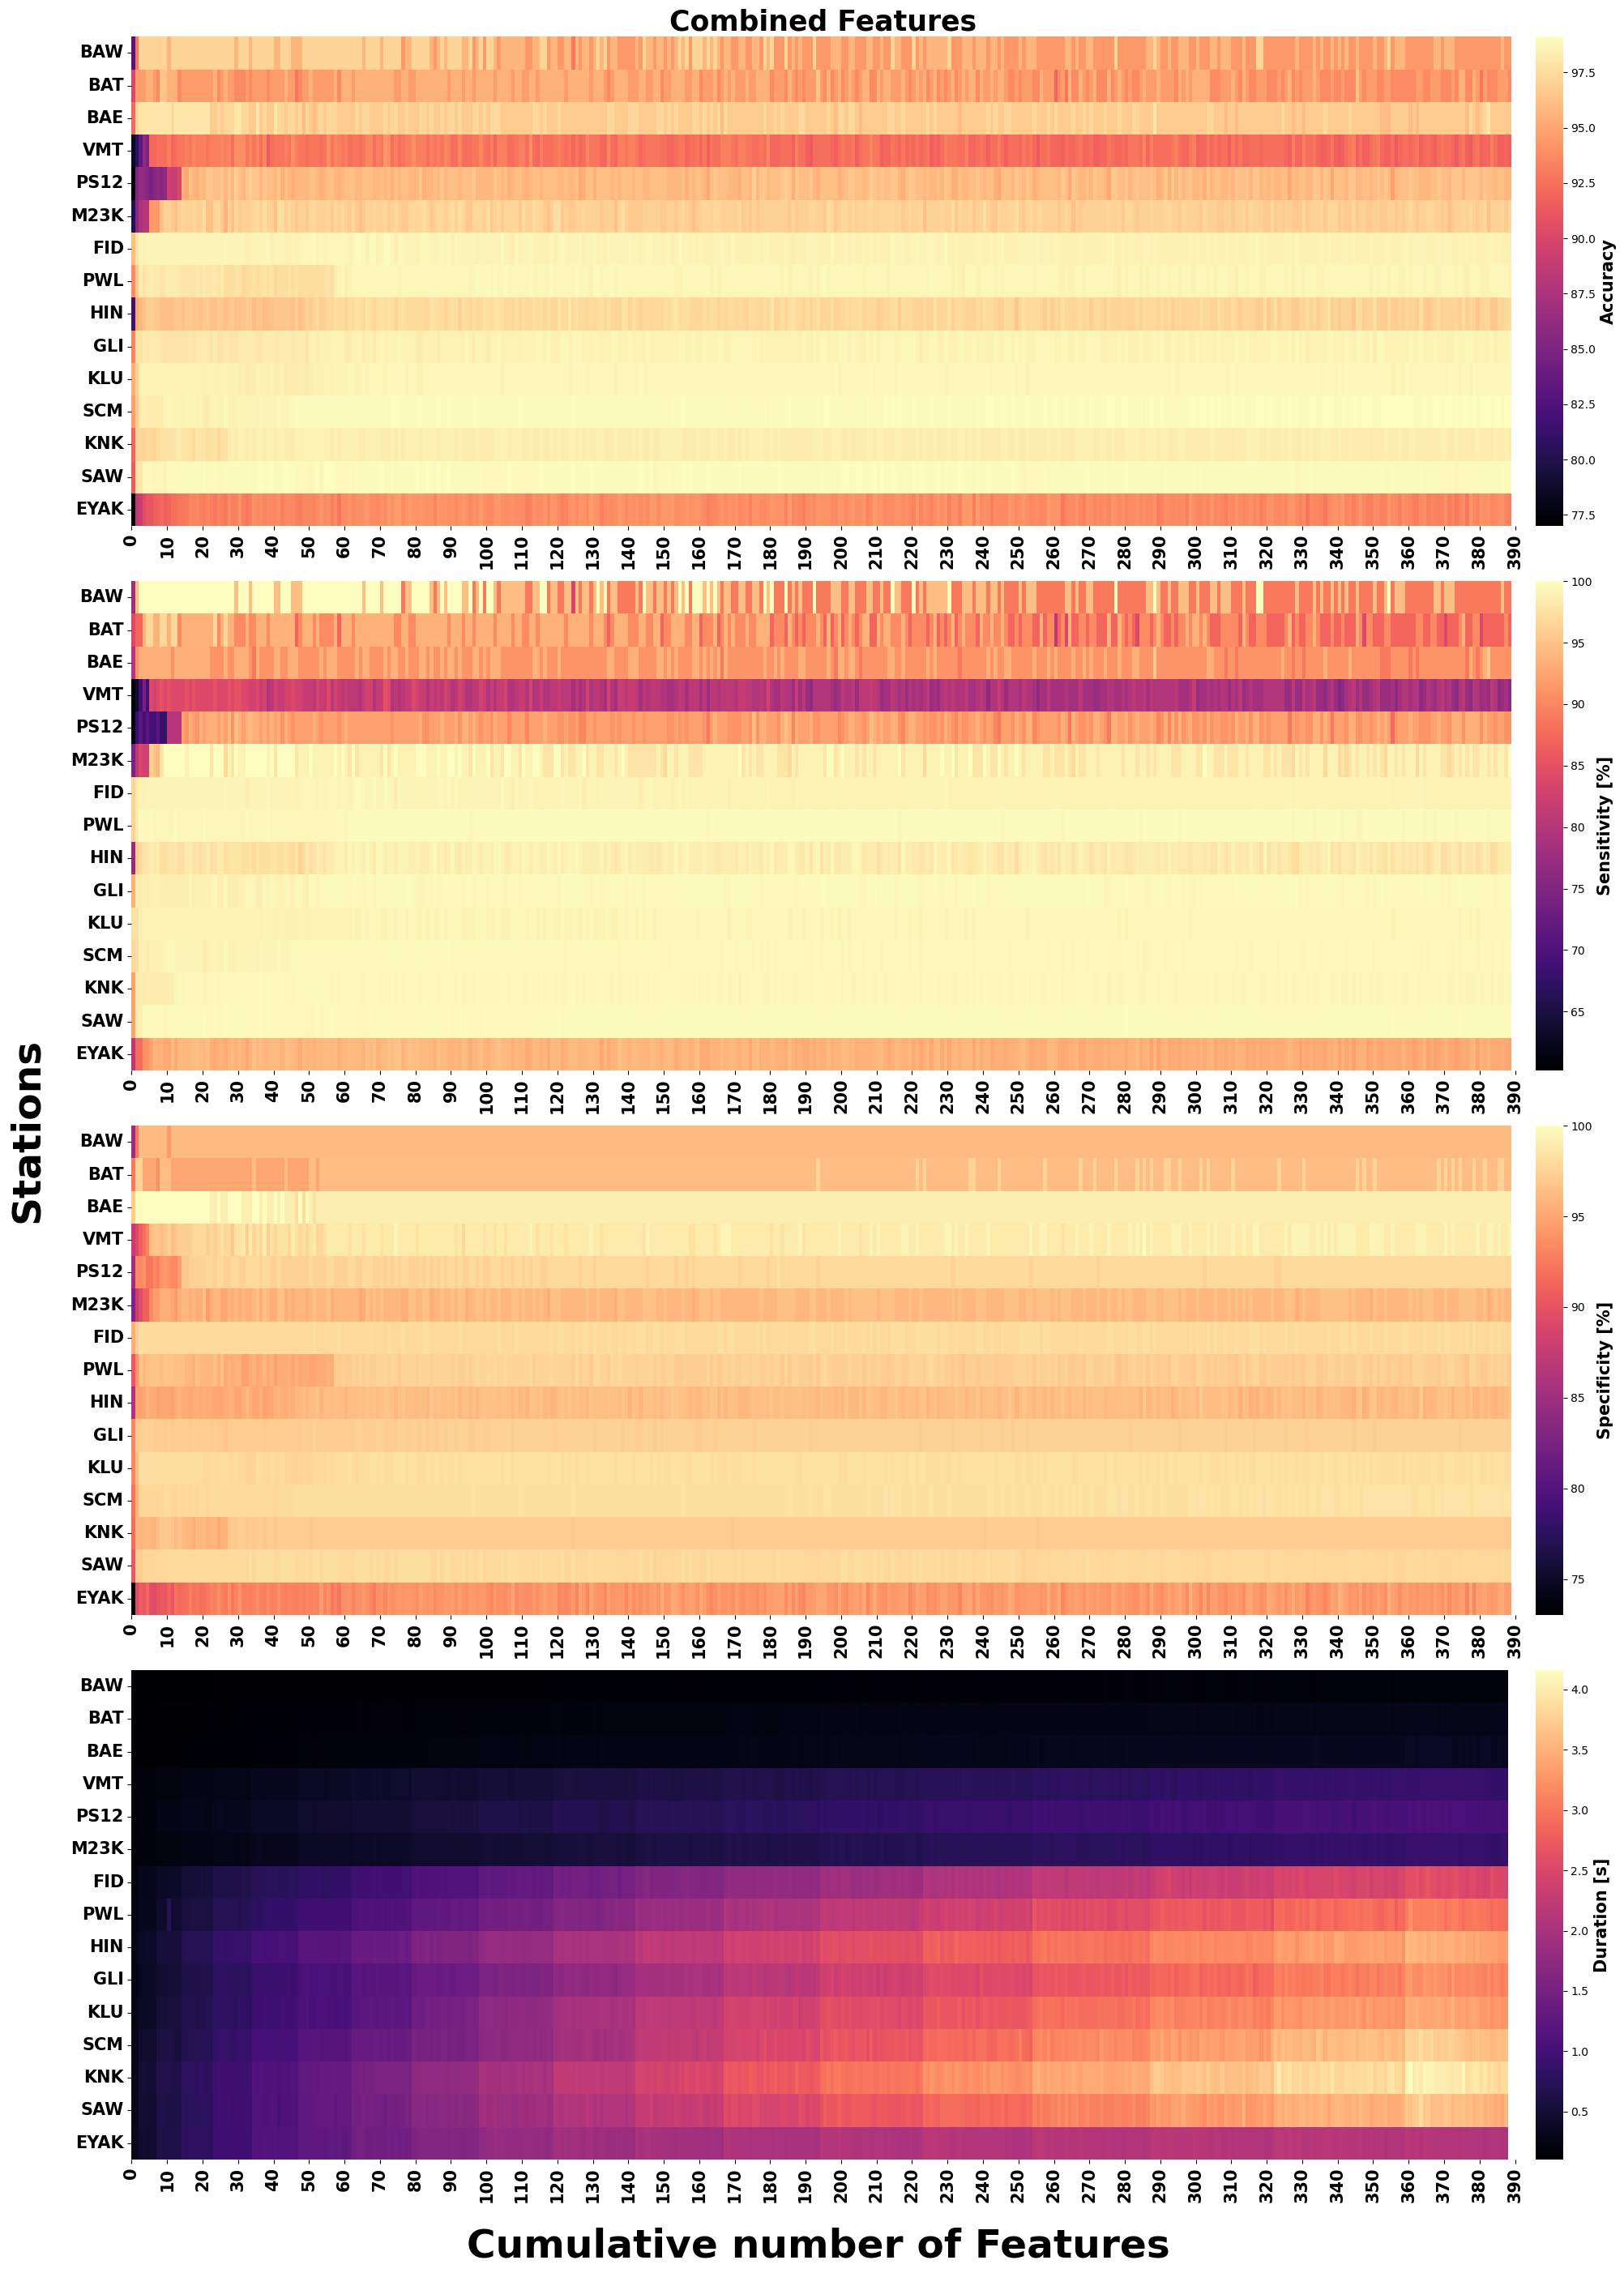

In [478]:
no_of_icequakes = []
no_of_earthquakes = []
for i in range(15):
    no_of_icequakes.append(len(glob('../Data/icequake_waveforms/*'+stations[i]+'*')))
    no_of_earthquakes.append(len(glob('../Data/earthquake_waveforms/*'+stations[i]+'*')))
    
    
total_events = np.array(no_of_icequakes)+np.array(no_of_earthquakes)
order = np.argsort(total_events)

    
plt.rcParams['axes.linewidth'] = 2
grid_spec = {"width_ratios": (25, 0.5)}

fig, ax1 = plt.subplots(4,2, gridspec_kw=grid_spec, figsize=[20,28])

ax = sns.heatmap(np.array(ACC)[order]*100,cbar_ax= ax1[0][1], ax=ax1[0][0], cmap = 'magma')
ax.set_xticks(np.linspace(0,390,40))
ax.set_xticklabels([str(i) for i in range(0,400,10)], fontsize=15, fontweight='bold')
ax.set_yticklabels(stations[order], fontsize=15, fontweight='bold', rotation=0)
#ax.set_xlabel('Feature #', fontsize=25, fontweight='bold')
#ax.set_ylabel('Stations', fontsize=25, fontweight='bold')
ax.set_title('Combined Features', fontsize=25, fontweight='bold')
ax1[0][1].set_ylabel('Accuracy', fontsize=15, fontweight='bold')

ax = sns.heatmap(np.array(SENS)[order]*100,cbar_ax= ax1[1][1], ax=ax1[1][0], cmap = 'magma')
ax.set_xticks(np.linspace(0,390,40))
ax.set_xticklabels([str(i) for i in range(0,400,10)], fontsize=15, fontweight='bold')
ax.set_yticklabels(stations[order], fontsize=15, fontweight='bold', rotation=0)
#ax.set_xlabel('Feature #', fontsize=25, fontweight='bold')
#ax.set_ylabel('Stations', fontsize=25, fontweight='bold')
#ax.set_title('Combined Features', fontsize=25, fontweight='bold')
ax1[1][1].set_ylabel('Sensitivity [%]', fontsize=15, fontweight='bold')


ax = sns.heatmap(np.array(SPEC)[order]*100,cbar_ax= ax1[2][1], ax=ax1[2][0], cmap = 'magma')
ax.set_xticks(np.linspace(0,390,40))
ax.set_xticklabels([str(i) for i in range(0,400,10)], fontsize=15, fontweight='bold')
ax.set_yticklabels(stations[order], fontsize=15, fontweight='bold', rotation=0)
#ax.set_xlabel('Feature #', fontsize=25, fontweight='bold')
#ax.set_ylabel('Stations', fontsize=25, fontweight='bold')
#ax.set_title('Combined Features', fontsize=25, fontweight='bold')
ax1[2][1].set_ylabel('Specificity [%]', fontsize=15, fontweight='bold')

    
ax = sns.heatmap(np.diff(np.array(DUR)[order]),cbar_ax= ax1[3][1], ax=ax1[3][0], cmap = 'magma')
ax.set_xticks(np.linspace(0,390,40))
ax.set_xticklabels([str(i) for i in range(0,400,10)], fontsize=15, fontweight='bold')
ax.set_yticklabels(stations[order], fontsize=15, fontweight='bold', rotation=0)
#ax.set_xlabel('Feature #', fontsize=25, fontweight='bold')
#ax.set_ylabel('Stations', fontsize=25, fontweight='bold')
#ax.set_title('Combined Features', fontsize=25, fontweight='bold')
ax1[3][1].set_ylabel('Duration [s]', fontsize=15, fontweight='bold')




fig.supxlabel('Cumulative number of Features', y = 0.0, fontsize = 35, fontweight = 'bold')
fig.supylabel('Stations', x = 0.0, fontsize = 35, fontweight = 'bold')

plt.tight_layout()